# The impact of meteorological parameters on air pollution

### Regression model development

#### Data preparation

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
import seaborn as sns
from sklearn import metrics, linear_model
from sklearn.impute import KNNImputer
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, explained_variance_score
from itertools import combinations
from sklearn.pipeline import Pipeline
from math import sqrt

In [2]:
data = pd.read_csv('./data/PRSA_Data_Nongzhanguan_20130301-20170228.csv', sep=',')
display(data.head())

,No,year,month,day,hour,PM2.5,PM10,SO2,NO2,CO,O3,TEMP,PRES,DEWP,RAIN,wd,WSPM,station
0,1,2013,3,1,0,5.0,14.0,4.0,12.0,200.0,85.0,-0.5,1024.5,-21.4,0.0,NNW,5.7,Nongzhanguan
1,2,2013,3,1,1,8.0,12.0,6.0,14.0,200.0,84.0,-0.7,1025.1,-22.1,0.0,NW,3.9,Nongzhanguan
2,3,2013,3,1,2,3.0,6.0,5.0,14.0,200.0,83.0,-1.2,1025.3,-24.6,0.0,NNW,5.3,Nongzhanguan
3,4,2013,3,1,3,5.0,5.0,5.0,14.0,200.0,84.0,-1.4,1026.2,-25.5,0.0,N,4.9,Nongzhanguan
4,5,2013,3,1,4,5.0,5.0,6.0,21.0,200.0,77.0,-1.9,1027.1,-24.5,0.0,NNW,3.2,Nongzhanguan


As described in the previous section of the project, we prepare the data by removing unnecessary columns, handling missing values, and converting the 'wd' feature into a numerical variable.

Since the dataset covers only one station, the 'station' feature contains a single unique value 'Nongzhanguan' so we remove this column. The 'No' column is merely a row counter and provides no meaningful information, so we decide to drop it as well.

In [3]:
data.drop(columns=['No', 'station'], inplace=True)

Based on the exploratory data analysis, missing values appear to be random. Removing these rows could negatively impact the model's quality, so we opt for numerical data imputation using the KNN method and remove missing categorical values.

In [4]:
numeric_features = ['PM2.5', 'PM10', 'SO2', 'NO2', 'CO', 'O3', 'TEMP', 'PRES', 'DEWP', 'RAIN', 'WSPM']
imputer = KNNImputer(n_neighbors=5)
numeric_data_imputed = imputer.fit_transform(data[numeric_features])
data[numeric_features] = numeric_data_imputed
data_cleaned = data.dropna(subset=['wd'])
data = data_cleaned

The wind direction ('wd') feature is not numerical in the original dataset, but after converting it into a numerical variable, it may show correlations with pollution levels. This could be an interesting aspect to examine further in the regression model.

In [5]:
wind_direction_mapping = {
    'N': 0, 'NNE': 22.5, 'NE': 45, 'ENE': 67.5, 'E': 90, 'ESE': 112.5, 'SE': 135, 'SSE': 157.5,
    'S': 180, 'SSW': 202.5,'SW': 225, 'WSW': 247.5, 'W': 270, 'WNW': 292.5, 'NW': 315, 'NNW': 337.5
}
data['wd_num'] = data['wd'].map(wind_direction_mapping)
numeric_features.append('wd_num')
data.drop(columns=['wd'], inplace=True)

# Multiple regression models

### 1. Linear regression

#### 1.1.1 Model using meteorological features to predict SO2 concentration.

We want to determine whether it is possible to predict sulfur dioxide concentration based on meteorological conditions. Therefore, we will first develop a regression model using only meteorological features from the dataset. The dataset also contains features related to other pollutants, which we will include in a subsequent model.

In [6]:
weather_features = ['TEMP', 'PRES', 'DEWP', 'RAIN', 'WSPM', 'wd_num'] 
target = 'SO2'

X = data[weather_features]
y = data[target]

Before training the model, we split the data into training and test sets.

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.2, random_state=0)

Since the features in our dataset have different scales, we standardize them to ensure equal weighting in computations. Each feature will now have a mean of 0 and a standard deviation of 1.

In [8]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
X_train = pd.DataFrame(X_train_scaled, columns=weather_features)  
X_test = pd.DataFrame(X_test_scaled, columns=weather_features) 

We create a linear regression model and make predictions on the test set.

In [9]:
regressor = LinearRegression()
regressor.fit(X_train, y_train)

y_pred = regressor.predict(X_test)

In [10]:
def plot_comparison(y_test, y_pred, title):
    plt.figure(figsize=(8,6))
    plt.scatter(y_test, y_pred, alpha=0.7, edgecolors='k')
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linestyle='--', linewidth=2)
    plt.title(title)  
    plt.xlabel("Actual SO2 values")  
    plt.ylabel("Predicted SO2 values")  
    
    plt.tight_layout()
    plt.show()

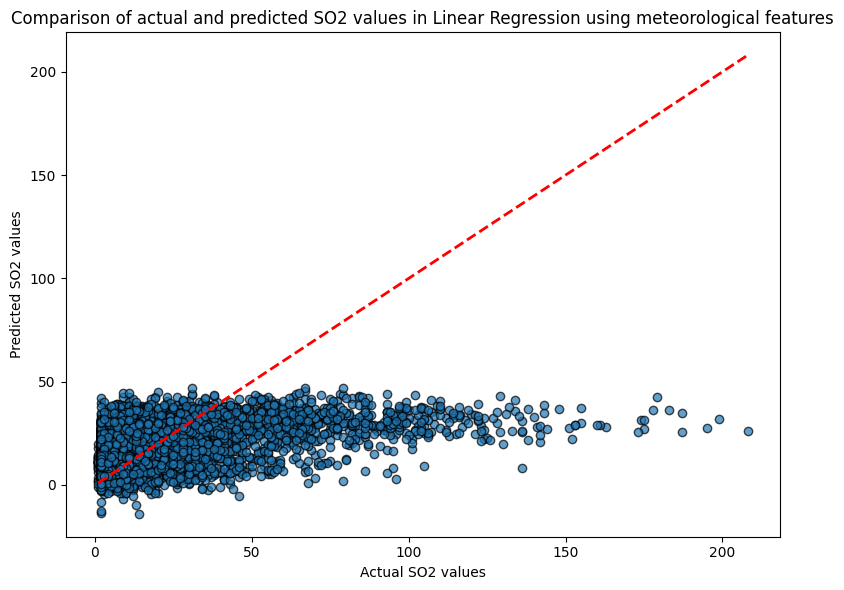

In [11]:
plot_comparison(y_test, y_pred, "Comparison of actual and predicted SO2 values in Linear Regression using meteorological features")

The comparison plot shows that the model predicts only low SO2 values—mainly up to 50$ug/m^3$ and struggles with higher, less common concentrations. The model systematically underestimates values, as seen by the majority of points lying below the red line.

To evaluate the model and compare it with others, we compute performance metrics.

In [12]:
def calculate_metrics(X_train, y_train, X_test, y_test, y_train_pred, y_test_pred):
    n_train = len(y_train)
    n_test = len(y_test)
    p = X_train.shape[1]

    mse_train = mean_squared_error(y_train, y_train_pred)
    rmse_train = mse_train**0.5
    mae_train = mean_absolute_error(y_train, y_train_pred)
    r2_train = r2_score(y_train, y_train_pred)
    r2_adjusted_train = 1 - (1 - r2_train) * (n_train - 1) / (n_train - p - 1)
    mape_train = np.mean(np.abs((y_train - y_train_pred) / y_train)) * 100
    mse_test = mean_squared_error(y_test, y_test_pred)
    rmse_test = mse_test**0.5
    mae_test = mean_absolute_error(y_test, y_test_pred)
    r2_test = r2_score(y_test, y_test_pred)
    r2_adjusted_test = 1 - (1 - r2_test) * (n_test - 1) / (n_test - p - 1)
    mape_test = np.mean(np.abs((y_test - y_test_pred) / y_test)) * 100

    metrics = {
        "Metric": ["MSE", "RMSE", "MAE", "MAPE (%)", "R²", "R² Adjusted"],
        "Train": [mse_train, rmse_train, mae_train, mape_train, r2_train, r2_adjusted_train],
        "Test": [mse_test, rmse_test, mae_test, mape_test, r2_test, r2_adjusted_test],
    }

    df_metrics = pd.DataFrame(metrics)
    print("\nModel metrics:")
    display(df_metrics.round(2))

    return df_metrics

In [13]:
y_train_pred = regressor.predict(X_train)
y_test_pred = regressor.predict(X_test)

errors_linear_weather = calculate_metrics(X_train, y_train, X_test, y_test, y_train_pred, y_test_pred)


Model metrics:


,Metric,Train,Test
0,MSE,488.63,485.03
1,RMSE,22.10,22.02
2,MAE,14.88,14.85
3,MAPE (%),216.28,216.99
4,R²,0.17,0.17
5,R² Adjusted,0.17,0.17


* The error values for the training and test sets are very similar, indicating that the model is stable and does not have a problem with overfitting.
* However, the high MAPE (Mean Absolute Percentage Error) suggests that the model struggles to accurately predict low SO2 values. This could be due to nonlinear dependencies or high data variability.
* The coefficient of determination (0.17) is quite low, meaning the model struggles to capture relationships between explanatory variables and SO2. This could indicate that the dependencies between SO2 and meteorological features are nonlinear, which we will investigate further. We may also consider adding additional features that better explain SO2 levels, including other air pollution indicators.

In [14]:
def count_coefficients(model, features):
    coefficients = pd.DataFrame({'Feature': features, 'Coefficient': model.coef_}).sort_values('Coefficient', ascending=False)

    plt.figure(figsize=(8, 6))
    ax = sns.barplot(data=coefficients, x='Coefficient', y='Feature')
    plt.title("Model coefficients")
    plt.xlabel("Coefficient")  
    plt.ylabel("Feature")  

    for i, (coef, feature) in enumerate(zip(coefficients['Coefficient'], coefficients['Feature'])):
        ax.text(coef, i, f'{coef:.1f}', va='center', ha='left' if coef > 0 else 'right', color='black')

    plt.tight_layout()
    plt.show()
    
    return coefficients

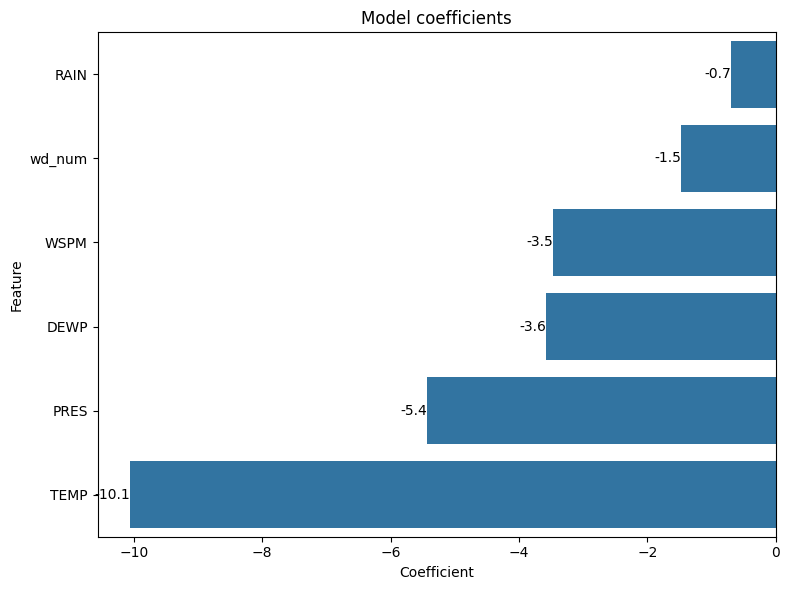

In [15]:
coefficients_linear_weather = count_coefficients(regressor, weather_features)

* The feature with the largest impact on SO2 concentration is temperature (TEMP), with a negative coefficient around -10. This aligns with our hypothesis—low temperatures contribute to higher SO2 concentrations.
* The next most influential feature is pressure (PRES), with a coefficient of around -5.5. Interestingly, while the correlation matrix suggested a positive correlation between SO2 and pressure, the model assigns it a negative coefficient. This might be due to interactions between features, as pressure depends on temperature, and these two variables are highly correlated. We may need to account for their interaction in the next steps.
* Wind speed (WSPM) and dew point temperature (DEWP) have similar coefficient magnitudes, while wind direction (wd_num) and rainfall (RAIN) have a relatively minor impact.

While analyzing the correlation matrix, we observed that variables such as TEMP and PRES or PRES and DEWP are highly correlated, which may indicate multicollinearity in the data. In such cases, it may be difficult to determine which variable actually influences the target feature. Let’s examine how regularization affects the model in this scenario.
##### 1.1.2 Ridge regularization for the meteorological features model
We use cross-validation to find the best regularization parameter.

In [16]:
param_grid_ridge = {'alpha': [0.01, 0.1, 1, 2, 4, 5, 6, 8, 10, 20, 40, 80, 100, 1000]}

ridge = Ridge(max_iter=10000)
ridge_cv = GridSearchCV(ridge, param_grid_ridge, cv=5, scoring='neg_mean_squared_error')
ridge_cv.fit(X_train, y_train)

best_ridge = ridge_cv.best_estimator_
y_test_pred = best_ridge.predict(X_test)
y_train_pred = best_ridge.predict(X_train)

print("\nBest alpha coefficient:", ridge_cv.best_params_)
errors_weather_ridge = calculate_metrics(X_train, y_train, X_test, y_test, y_train_pred, y_test_pred)


Best alpha coefficient: {'alpha': 6}

Model metrics:


,Metric,Train,Test
0,MSE,488.63,485.03
1,RMSE,22.10,22.02
2,MAE,14.88,14.85
3,MAPE (%),216.28,217.00
4,R²,0.17,0.17
5,R² Adjusted,0.17,0.17


In [17]:
def plot_metrics(df_metrics):
    plt.figure(figsize=(14, 6))
    plt.subplot(1, 2, 1)
    plt.plot(df_metrics["Alpha"], df_metrics["MSE Train"], marker='o', label="Training Error")
    plt.plot(df_metrics["Alpha"], df_metrics["MSE Test"], marker='o', label="Validation Error")
    plt.xlabel("alpha")
    plt.xscale('log')
    plt.ylabel("MSE")
    plt.title("Training and validation error vs. alpha")
    plt.grid(True)
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(df_metrics["Alpha"], df_metrics["R² Test"], marker='o', label="R² Test")
    plt.xlabel("alpha")
    plt.xscale('log')
    plt.ylabel("R²")
    plt.title("R² Test vs. Alpha")
    plt.grid(True)
    plt.legend()
    
    plt.tight_layout()
    plt.show()


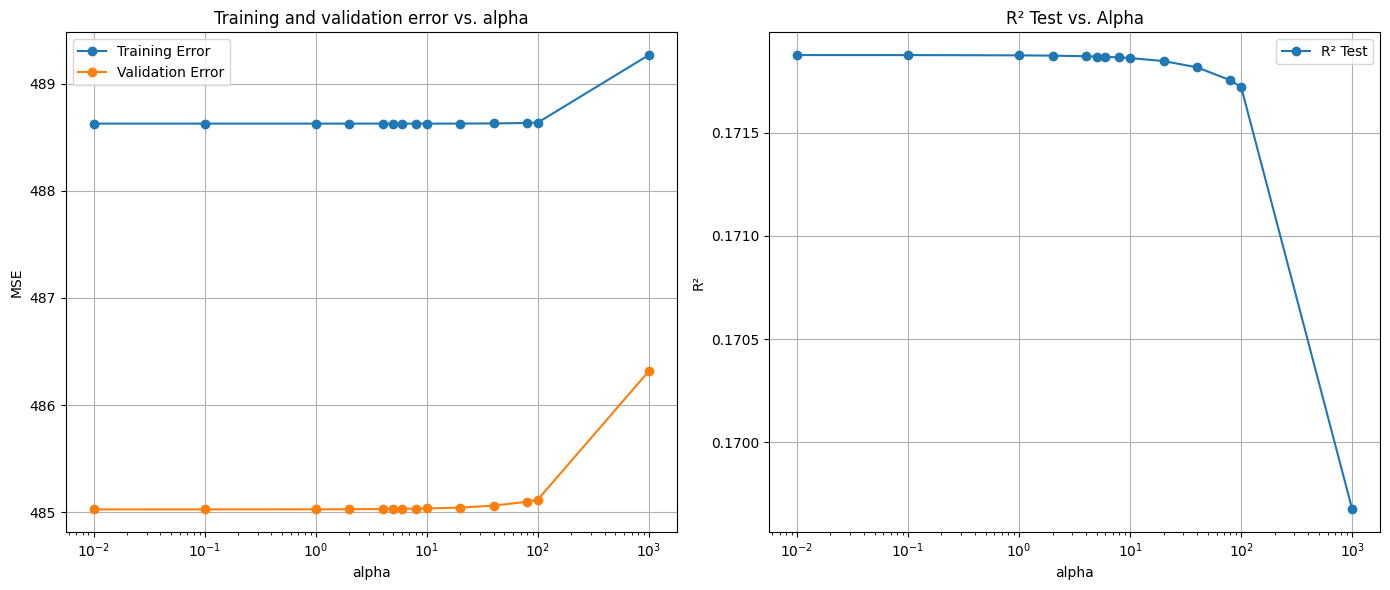

In [18]:
metrics_per_alpha_ridge = []

for alpha in param_grid_ridge['alpha']:
    ridge.set_params(alpha=alpha)
    ridge.fit(X_train, y_train)
    y_test_pred = ridge.predict(X_test)
    y_train_pred = ridge.predict(X_train)
    
    mse_train = mean_squared_error(y_train, y_train_pred)
    mse_test = mean_squared_error(y_test, y_test_pred)
    r2_test = r2_score(y_test, y_test_pred)
    
    metrics_per_alpha_ridge.append({
        "Alpha": alpha,
        "MSE Train": mse_train,
        "MSE Test": mse_test,
        "R² Test": r2_test
    })
df_metrics_ridge = pd.DataFrame(metrics_per_alpha_ridge)

plot_metrics(df_metrics_ridge)

The metrics for the Ridge model and the standard linear model are almost identical—Ridge regularization does not improve prediction quality for this dataset, but it also does not degrade it. The coefficients in the Ridge model are slightly shrunk toward zero compared to the standard model.

Now, let’s examine how Lasso regularization affects model performance.
##### 1.1.3 Lasso regularization for the meteorological features model

In [19]:
def calculate_metrics_and_zeroed_features(model, X_train, y_train, X_test, y_test, features):
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    
    mse_train = mean_squared_error(y_train, y_train_pred)
    mse_test = mean_squared_error(y_test, y_test_pred)
    r2_test = r2_score(y_test, y_test_pred)
    
    zeroed_features = [feature for coef, feature in zip(model.coef_, features) if coef == 0.0]
    
    return {
        "Alpha": alpha,
        "MSE Train": mse_train,
        "MSE Test": mse_test,
        "R² Test": r2_test,
        "Zeroed": zeroed_features
    }

In [20]:
lasso = Lasso(max_iter=10000)
param_grid_lasso = {'alpha': [0.001, 0.005, 0.01, 0.1, 0.5, 1, 2, 4]}
lasso_cv = GridSearchCV(lasso, param_grid_lasso, cv=5, scoring='neg_mean_squared_error')
lasso_cv.fit(X_train, y_train)

best_lasso = lasso_cv.best_estimator_
lasso_coeffs = pd.DataFrame({'Feature': weather_features, 'Coefficient': best_lasso.coef_})
y_train_pred = best_lasso.predict(X_train)
y_test_pred = best_lasso.predict(X_test)

print("Best alpha (Lasso):", lasso_cv.best_params_)
errors_weather_lasso = calculate_metrics(X_train, y_train, X_test, y_test, y_train_pred, y_test_pred)

Best alpha (Lasso): {'alpha': 0.001}

Model metrics:


,Metric,Train,Test
0,MSE,488.63,485.03
1,RMSE,22.10,22.02
2,MAE,14.88,14.85
3,MAPE (%),216.28,217.00
4,R²,0.17,0.17
5,R² Adjusted,0.17,0.17


Alfa: 0.001, Zeroed: []
Alfa: 0.005, Zeroed: []
Alfa: 0.01, Zeroed: []
Alfa: 0.1, Zeroed: []
Alfa: 0.5, Zeroed: []
Alfa: 1, Zeroed: ['PRES', 'DEWP', 'RAIN']
Alfa: 2, Zeroed: ['PRES', 'DEWP', 'RAIN', 'wd_num']
Alfa: 4, Zeroed: ['PRES', 'DEWP', 'RAIN', 'WSPM', 'wd_num']


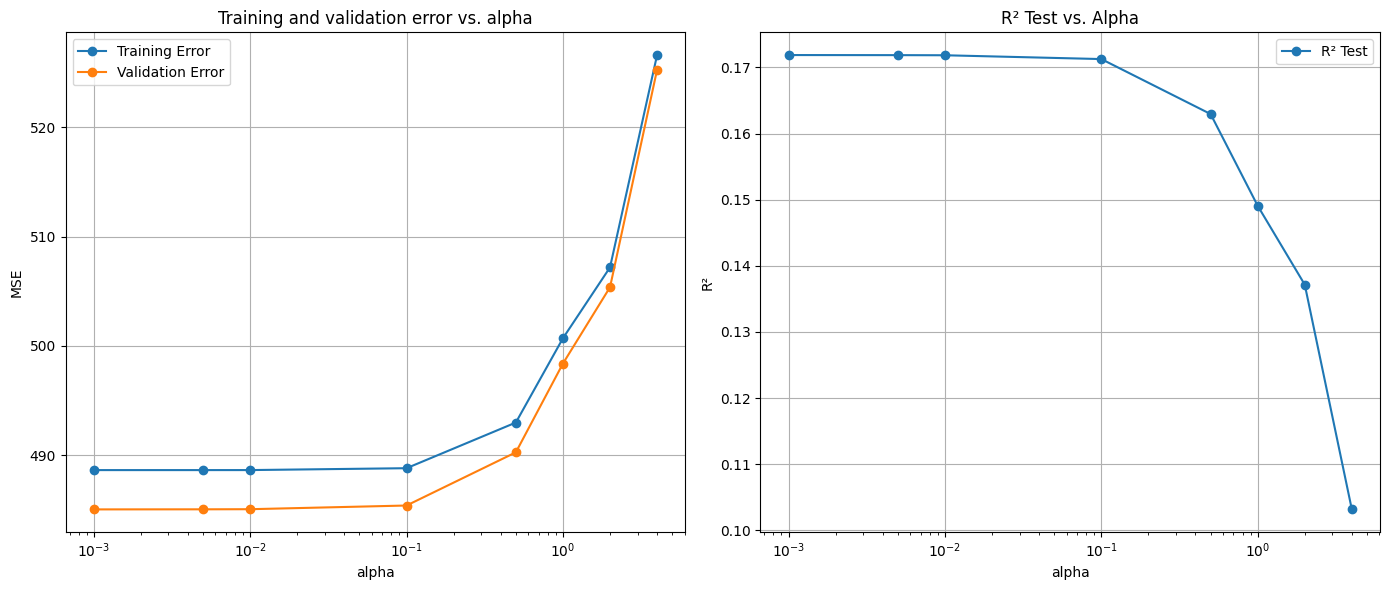

In [21]:
metrics_per_alpha = []
for alpha in param_grid_lasso['alpha']:
    lasso.set_params(alpha=alpha)
    lasso.fit(X_train, y_train)
    metrics = calculate_metrics_and_zeroed_features(lasso, X_train, y_train, X_test, y_test, X_train.columns)
    metrics["Alpha"] = alpha
    metrics_per_alpha.append(metrics)
    print(f"Alfa: {alpha}, Zeroed: {metrics['Zeroed']}")
df_metrics_lasso = pd.DataFrame(metrics_per_alpha).drop(columns=["Zeroed"])

plot_metrics(df_metrics_lasso)

* The best alpha for Lasso was 0.001, which is the lowest level of regularization tested. Lasso did not remove any features, indicating that all features contribute at least some information.
* Model performance is identical to the non-regularized model. Lasso regularization did not improve prediction quality or stability.
* The model does not suffer from overfitting, and the dataset contains relatively few features, making Lasso less beneficial.

In [22]:
def plot_model_metrics(models):
    train_mae = [errors["Train"][2] for errors in models.values()]
    test_mae = [errors["Test"][2] for errors in models.values()]
    train_mse = [errors["Train"][0] for errors in models.values()]
    test_mse = [errors["Test"][0] for errors in models.values()]
    train_rmse = [errors["Train"][1] for errors in models.values()]
    test_rmse = [errors["Test"][1] for errors in models.values()]
    train_r2 = [errors["Train"][4] for errors in models.values()]
    test_r2 = [errors["Test"][4] for errors in models.values()]

    metrics = {
        "MAE": (train_mae, test_mae),
        "MSE": (train_mse, test_mse),
        "R²": (train_r2, test_r2),
    }

    labels = list(models.keys())
    x = np.arange(len(labels))
    width = 0.35
    
    for metric, (train_values, test_values) in metrics.items():
        fig, ax = plt.subplots(figsize=(15, 8))
        ax.bar(x - width / 2, train_values, width, label="Train")
        ax.bar(x + width / 2, test_values, width, label="Test")
        ax.set_ylabel(metric)
        ax.set_title(f'Comparison of {metric} for models')
        ax.set_xticks(x)
        ax.set_xticklabels(labels, rotation=45, ha="right", fontsize=10)
        plt.subplots_adjust(bottom=0.3)
        ax.legend()
        plt.tight_layout()
        plt.show()

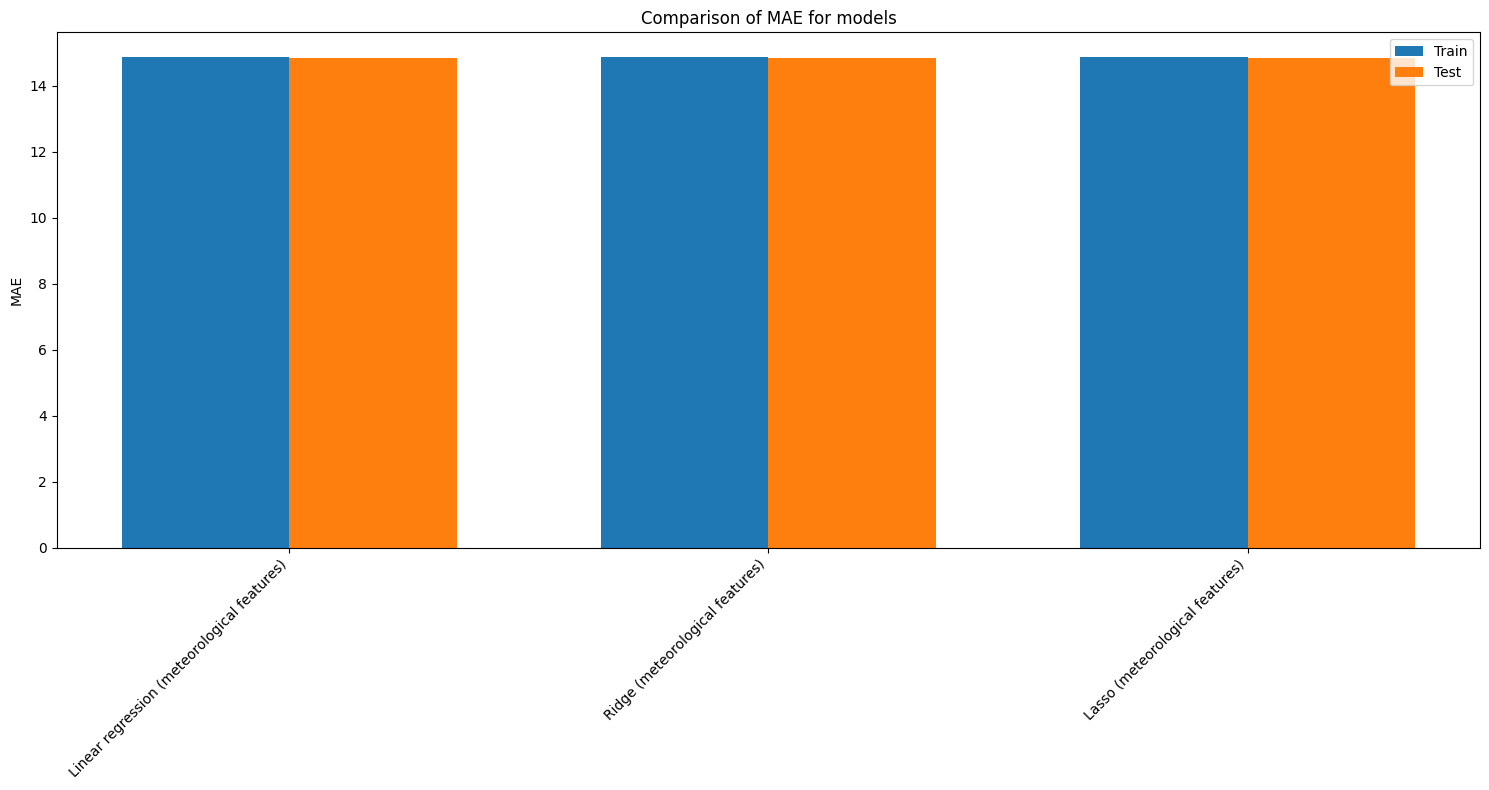

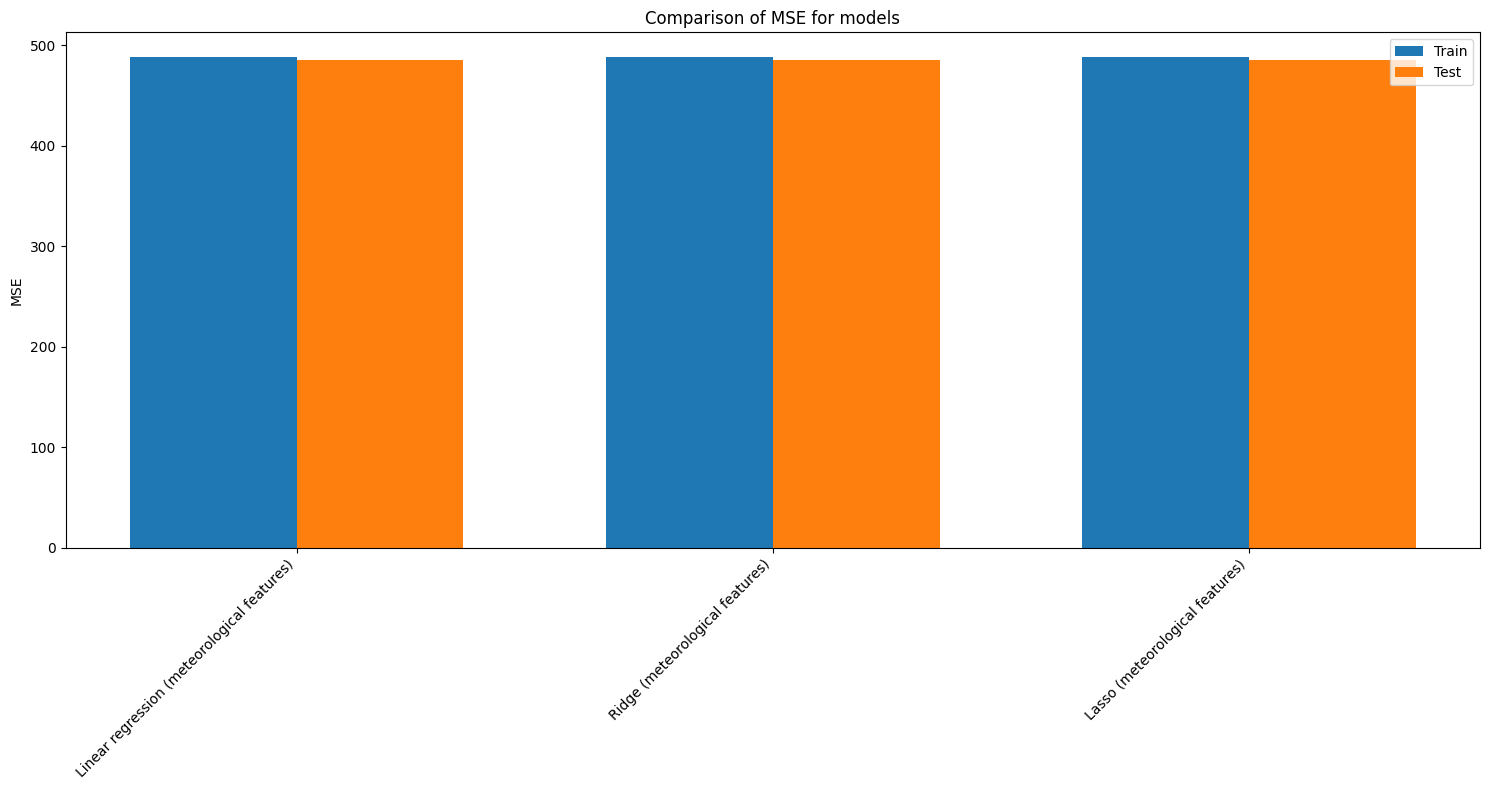

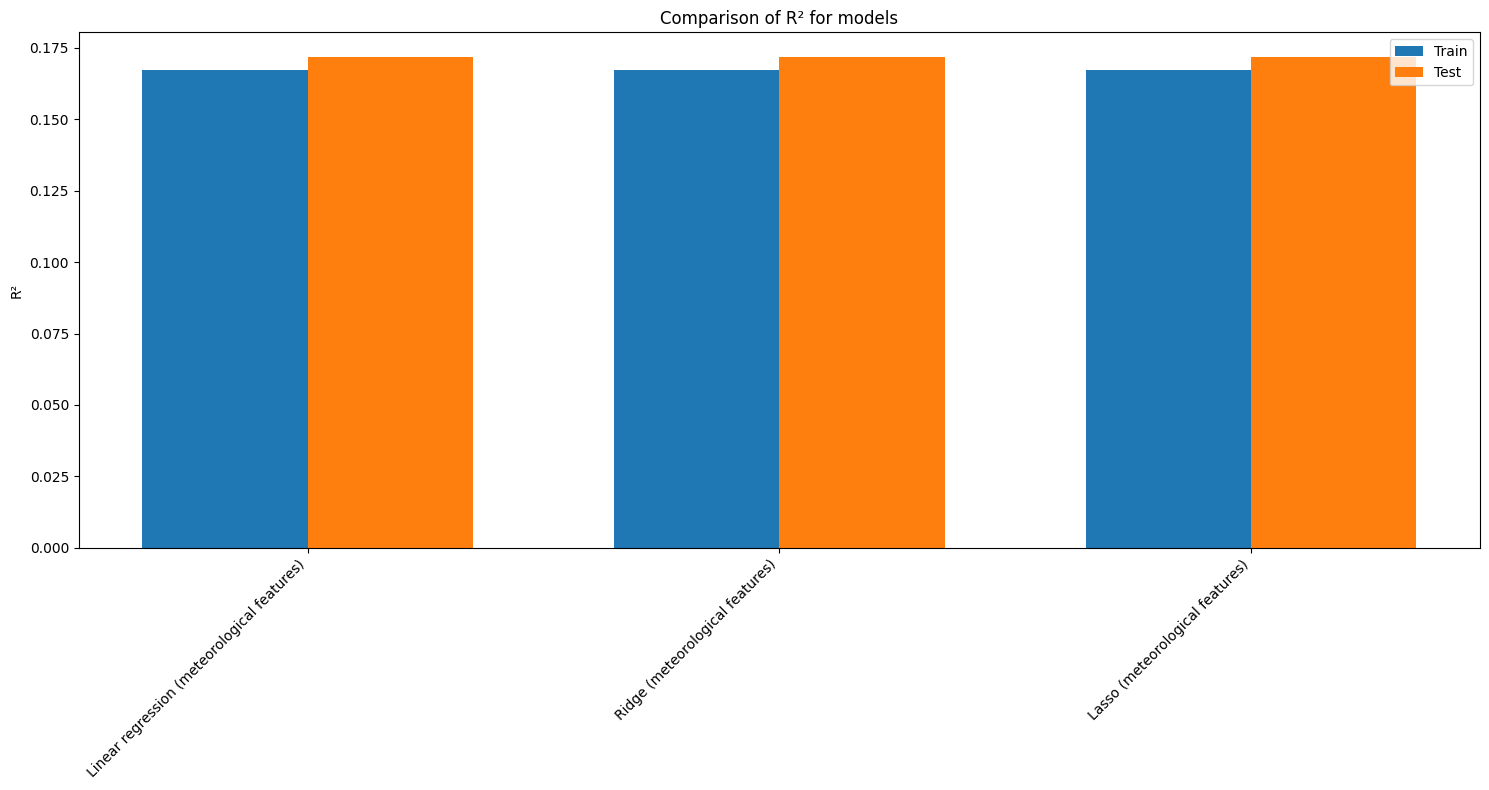

In [23]:
models = {
    "Linear regression (meteorological features)": errors_linear_weather,
    "Ridge (meteorological features)": errors_weather_ridge,
    "Lasso (meteorological features)": errors_weather_lasso,
}

plot_model_metrics(models)

### Conclusions for the meteorological features models

* The quality of the models analysed is very low: $R^2$ (at 17%) means that atmospheric conditions explain a small part of the variability in SO2 concentrations.  Also the RMSE, at about $22$ug/m^3$, is quite high relative to the range of SO2 values. There is no overfitting in the model, but the problem may be insufficient information in the weather variables or non-linear relationships. The model clearly failed to capture an important part of the pollution dependence of meteorological conditions and is too inaccurate to be used to predict SO2 pollution concentrations.
* TEMP (temperature) turned out to be the most important parameter, with the largest negative coefficient (about -10). This is consistent with the hypothesis that lower temperature favours higher SO2 concentrations.
* Traits such as PRES, DEWP and WSPM also have negative coefficients, but a slightly smaller influence compared to temperature. The PRES coefficient at ca. -5.4 is the second largest parameter, which does not support the second part of our hypothesis - that wind speed is the second most significant feature.
* Ridge regularization was not helpful in this case.
* Lasso did not zero out any features, suggesting that each feature contributes at least some information; at the same time, the model only explains about 17% of the variability anyway.
* Simply relying on the weather proves insufficient, so we will now explore models incorporating:
   * temporal data
   * other pollutants.

#### 1.2.1 Linear Regression model including meteorological and pollutant features

In [24]:
features = ['PM2.5', 'PM10', 'NO2', 'CO', 'O3', 'TEMP', 'PRES', 'DEWP', 'RAIN', 'WSPM', 'wd_num']
target = 'SO2'

X = data[features]
y = data[target]

In [25]:
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.2, random_state=0)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
X_train = pd.DataFrame(X_train_scaled, columns=features)  
X_test = pd.DataFrame(X_test_scaled, columns=features) 

In [26]:
regressor = LinearRegression()
regressor.fit(X_train, y_train)

y_train_pred = regressor.predict(X_train)
y_test_pred = regressor.predict(X_test)

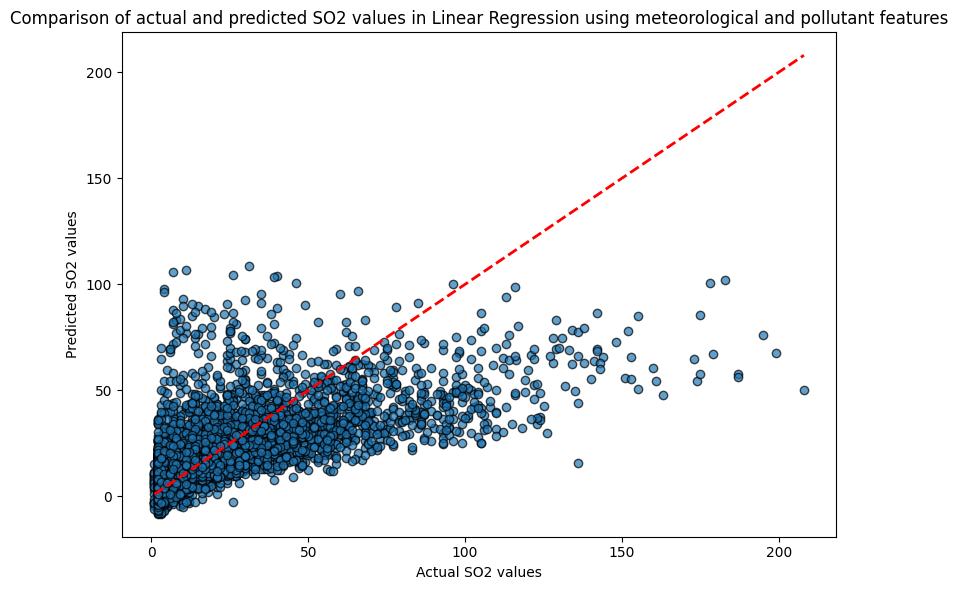

In [27]:
plot_comparison(y_test, y_test_pred, "Comparison of actual and predicted SO2 values in Linear Regression using meteorological and pollutant features")

* Although the plot still shows significant discrepancies, particularly for high SO2 concentrations, the model using all features provides a much better approximation of actual sulfur dioxide values. This makes sense, as SO2 is strongly correlated with other pollutants, which is also visible in the correlation matrix.

In [28]:
errors_all = calculate_metrics(X_train, y_train, X_test, y_test, y_train_pred, y_test_pred)


Model metrics:


,Metric,Train,Test
0,MSE,324.32,318.49
1,RMSE,18.01,17.85
2,MAE,11.08,11.05
3,MAPE (%),134.36,136.06
4,R²,0.45,0.46
5,R² Adjusted,0.45,0.46


* The root mean squared error (RMSE) of this model is significantly reduced—over 4 units lower than the model using only meteorological features.
* As expected, the $R^2$ coefficient of determination is significantly better.

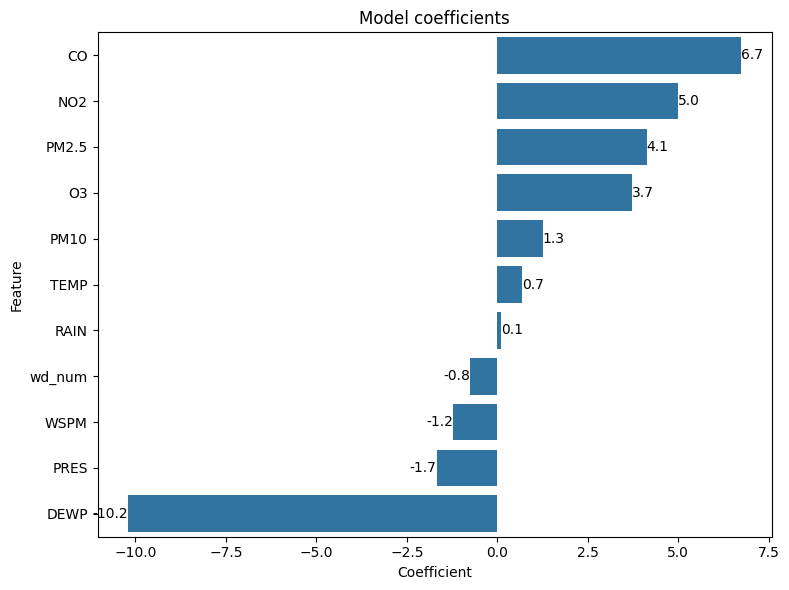

In [29]:
coefficients = count_coefficients(regressor, features)

* Despite a moderately high correlation between the dependent variable (SO2) and TEMP (temperature, also included in our hypothesis), the coefficient for this feature in our linear regression model is very low (0.7). This could be due to interactions with other, more strongly correlated features, which weaken the importance of temperature. 
* However, the largest coefficient value in the table is negative (-10.2) and corresponds to DEWP (dew point temperature). This might indicate that high humidity leads to conditions favoring SO2 decomposition.
* Other pollutant features, such as CO, NO2, and PM2.5, have high coefficients. This suggests that they originate from similar sources and are often emitted together. Their presence allows for more accurate predictions of sulfur dioxide concentrations, which was also evident in the correlation matrix.

##### Selecting the most important features using a greedy method

In [30]:
def best_features(X_train, y_train, features):
    best_features = []
    errors = [] 
    model = LinearRegression()
    
    for i in range(1, len(features) + 1):
        best_combination = None
        best_err = float('inf')
        for combination in combinations(features, i):
            X_feat = X_train[list(combination)]
            error = -cross_val_score(model, X_feat, y_train, cv=5, scoring='neg_mean_squared_error').mean()

            if error < best_err:
                best_err = error
                best_combination = combination
                
        best_features.append(best_combination)
        errors.append(best_err)
        print(f"For {i} features: {best_combination}")  
        print(f"MSE Error: {best_err}\n")  
        
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, len(errors) + 1), errors, marker='o')
    plt.xlabel("Number of features")
    plt.ylabel("MSE error")  
    plt.title("MSE error vs. number of features")  
    plt.show()
    
    return best_features

For 1 features: ('CO',)
MSE Error: 397.50253388993394

For 2 features: ('CO', 'DEWP')
MSE Error: 359.04369487793764

For 3 features: ('PM2.5', 'CO', 'DEWP')
MSE Error: 341.94802894802086

For 4 features: ('NO2', 'CO', 'O3', 'DEWP')
MSE Error: 333.7849040076456

For 5 features: ('PM2.5', 'NO2', 'CO', 'O3', 'DEWP')
MSE Error: 327.52547374705415

For 6 features: ('PM2.5', 'NO2', 'CO', 'O3', 'PRES', 'DEWP')
MSE Error: 326.6202812146822

For 7 features: ('PM2.5', 'NO2', 'CO', 'O3', 'PRES', 'DEWP', 'WSPM')
MSE Error: 325.67618977635595

For 8 features: ('PM2.5', 'NO2', 'CO', 'O3', 'PRES', 'DEWP', 'WSPM', 'wd_num')
MSE Error: 325.21693775040274

For 9 features: ('PM2.5', 'PM10', 'NO2', 'CO', 'O3', 'PRES', 'DEWP', 'WSPM', 'wd_num')
MSE Error: 324.9977950192054

For 10 features: ('PM2.5', 'PM10', 'NO2', 'CO', 'O3', 'TEMP', 'PRES', 'DEWP', 'WSPM', 'wd_num')
MSE Error: 324.97871413771753

For 11 features: ('PM2.5', 'PM10', 'NO2', 'CO', 'O3', 'TEMP', 'PRES', 'DEWP', 'RAIN', 'WSPM', 'wd_num')
MSE E

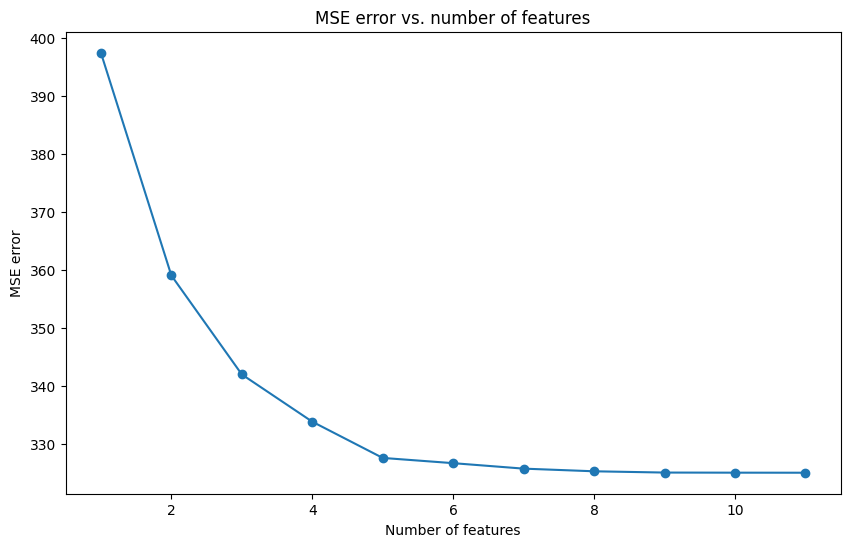

In [31]:
best_features_all = best_features(X_train, y_train, features)

* Greedy feature selection confirms that the most important features are pollutants (CO, NO2, PM2.5, O3) and DEWP (dew point temperature).
* Adding more features (PRES, WSPM, wd_num, PM10, etc.) continues to slightly reduce MSE until nearly all are included. This indicates that the model indeed benefits from each additional variable, but the improvement is minimal.

##### 1.2.3 Regression model with transformed features

The dataset also contains information about the date of measurement. During exploratory analysis, we observed that sulfur dioxide (SO2) concentration follows seasonal patterns. Let’s incorporate these features and account for monthly trends and their cyclic nature by transforming the month variable into sine and cosine variables. Additionally, we observed that SO2 concentration has been systematically decreasing throughout the measurement period, so we can include a time trend.

In [32]:
data['month_sin'] = np.sin(2 * np.pi * data['month'] / 12)
data['month_cos'] = np.cos(2 * np.pi * data['month'] / 12)
data['time'] = (data['year'] - data['year'].min()) * 12 + data['month']

In [33]:
features_extended = ['PM2.5', 'PM10', 'NO2', 'CO', 'O3', 'TEMP', 'PRES', 'DEWP', 'RAIN', 'WSPM', 'wd_num','month_sin', 'month_cos', 'time'] 
X_extended = data[features_extended]
y = data['SO2']

X_train, X_test, y_train, y_test = train_test_split(X_extended, y, test_size=0.2, random_state=0)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
X_train = pd.DataFrame(X_train_scaled, columns=features_extended)  
X_test = pd.DataFrame(X_test_scaled, columns=features_extended) 

regressor = LinearRegression()
regressor.fit(X_train, y_train)
y_train_pred = regressor.predict(X_train)
y_test_pred = regressor.predict(X_test)


Model metrics:


,Metric,Train,Test
0,MSE,276.45,272.90
1,RMSE,16.63,16.52
2,MAE,10.81,10.82
3,MAPE (%),149.78,149.79
4,R²,0.53,0.53
5,R² Adjusted,0.53,0.53


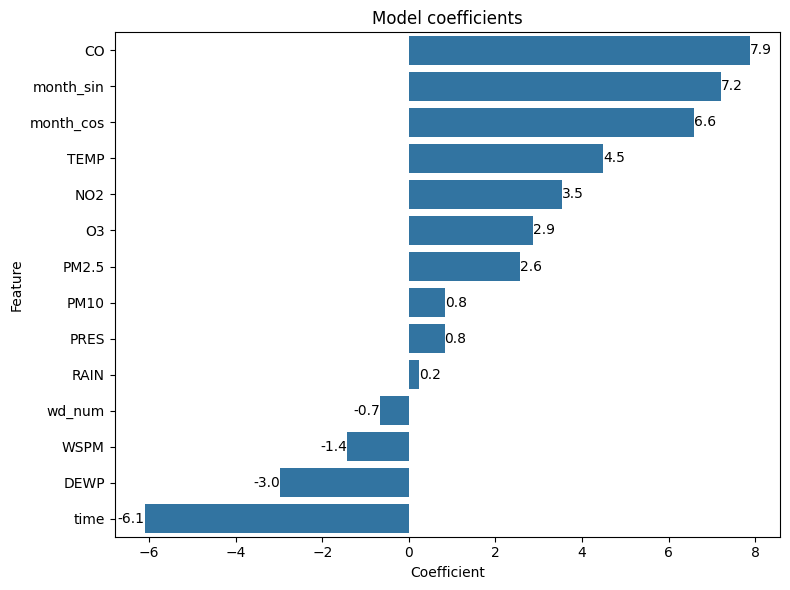

In [34]:
errors_all_ext_time = calculate_metrics(X_train, y_train, X_test, y_test, y_train_pred, y_test_pred)
coefficients_ext = count_coefficients(regressor, features_extended)

* The introduction of new features reduced errors, indicating a better model fit. The transformed variables successfully captured SO2 seasonality. Our hypothesis about seasonal patterns and the long-term decreasing trend in SO2 concentration was correct, and incorporating this information improved the model.

Data distribution analysis showed that variables such as RAIN, O₃, CO, PM10, and PM2.5 have highly skewed distributions. Therefore, we apply a logarithmic transformation and examine its effect on model performance.

In [35]:
data['log_PM2.5'] = np.log1p(data['PM2.5'])
data['log_PM10'] = np.log1p(data['PM10'])
data['log_CO'] = np.log1p(data['CO'])
data['log_O3'] = np.log1p(data['O3'])

In [36]:
features_extended = ['TEMP', 'PRES', 'DEWP', 'RAIN', 'WSPM', 'wd_num', 'log_PM2.5', 'log_PM10', 'log_CO', 'log_O3']

X_extended = data[features_extended]
y = data['SO2']

X_train, X_test, y_train, y_test = train_test_split(X_extended, y, test_size=0.2, random_state=0)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
X_train = pd.DataFrame(X_train_scaled, columns=features_extended)  
X_test = pd.DataFrame(X_test_scaled, columns=features_extended) 

regressor = LinearRegression()
regressor.fit(X_train, y_train)
y_train_pred = regressor.predict(X_train)
y_test_pred = regressor.predict(X_test)


Model metrics:


,Metric,Train,Test
0,MSE,293.38,289.14
1,RMSE,17.13,17.00
2,MAE,11.25,11.11
3,MAPE (%),158.15,156.07
4,R²,0.50,0.51
5,R² Adjusted,0.50,0.51


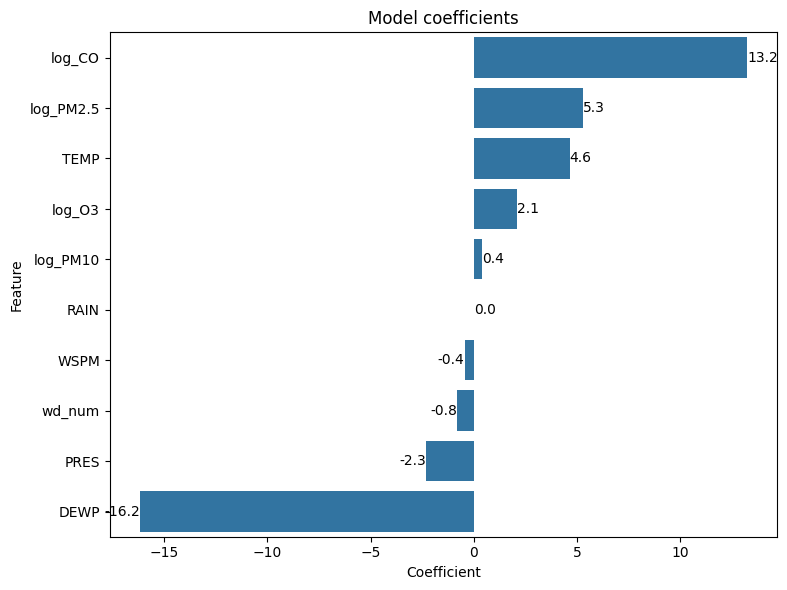

In [37]:
errors_all_ext_log = calculate_metrics(X_train, y_train, X_test, y_test, y_train_pred, y_test_pred)
coefficients_ext_log = count_coefficients(regressor, features_extended)

* Adding logarithmically transformed variables provided a small improvement—RMSE dropped to around 17.

Now, let’s analyze how the model performs when combining the previously proposed features.

In [38]:
features_extended = [
    'TEMP', 'PRES', 'DEWP', 'RAIN', 'WSPM', 'wd_num', 'log_PM2.5', 'log_PM10', 
    'log_CO', 'log_O3','month_sin', 'month_cos', 'time']


Model metrics:


,Metric,Train,Test
0,MSE,260.63,255.02
1,RMSE,16.14,15.97
2,MAE,10.84,10.74
3,MAPE (%),164.52,162.16
4,R²,0.56,0.56
5,R² Adjusted,0.56,0.56


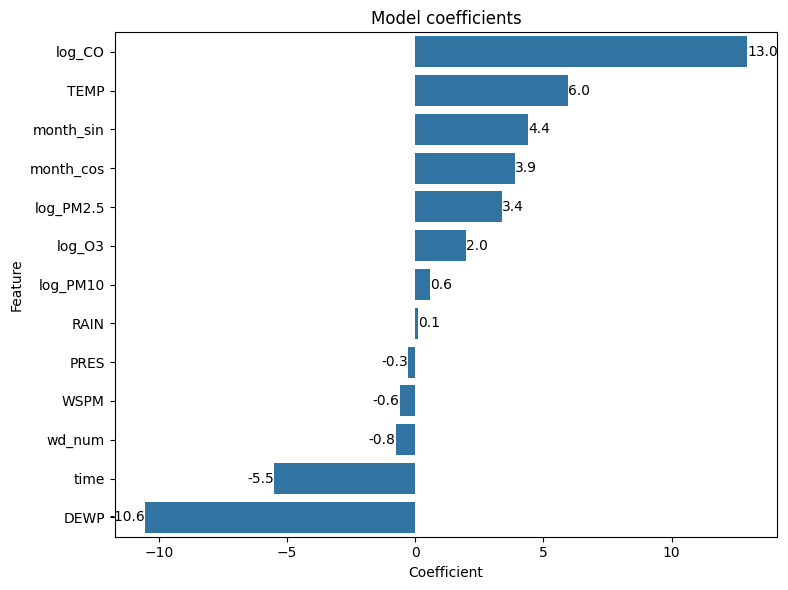

In [39]:
X_extended = data[features_extended]
y = data['SO2']

X_train, X_test, y_train, y_test = train_test_split(X_extended, y, test_size=0.2, random_state=0)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
X_train = pd.DataFrame(X_train_scaled, columns=features_extended)  
X_test = pd.DataFrame(X_test_scaled, columns=features_extended) 

regressor = LinearRegression()
regressor.fit(X_train, y_train)
y_train_pred = regressor.predict(X_train)
y_test_pred = regressor.predict(X_test)

errors_all_ext_all = calculate_metrics(X_train, y_train, X_test, y_test, y_train_pred, y_test_pred)
coefficients_ext_all = count_coefficients(regressor, features_extended)

The results show that MSE decreases to ~260, RMSE to ~16, and $R^2$ increases to 0.56, indicating significantly better performance than models without transformations.

For 1 features: ('log_CO',)
MSE Error: 398.7787990410202

For 2 features: ('DEWP', 'log_CO')
MSE Error: 322.32745394292465

For 3 features: ('DEWP', 'log_CO', 'time')
MSE Error: 288.40576799083897

For 4 features: ('DEWP', 'log_CO', 'month_sin', 'time')
MSE Error: 277.19604699956574

For 5 features: ('DEWP', 'log_PM2.5', 'log_CO', 'log_O3', 'time')
MSE Error: 269.0798052886351

For 6 features: ('TEMP', 'DEWP', 'log_PM2.5', 'log_CO', 'month_sin', 'time')
MSE Error: 265.0655471339534

For 7 features: ('TEMP', 'DEWP', 'log_PM2.5', 'log_CO', 'month_sin', 'month_cos', 'time')
MSE Error: 263.17293282167293

For 8 features: ('TEMP', 'DEWP', 'log_PM2.5', 'log_CO', 'log_O3', 'month_sin', 'month_cos', 'time')
MSE Error: 261.81398504123814

For 9 features: ('TEMP', 'DEWP', 'wd_num', 'log_PM2.5', 'log_CO', 'log_O3', 'month_sin', 'month_cos', 'time')
MSE Error: 261.2017424189578

For 10 features: ('TEMP', 'DEWP', 'WSPM', 'wd_num', 'log_PM2.5', 'log_CO', 'log_O3', 'month_sin', 'month_cos', 'time')
M

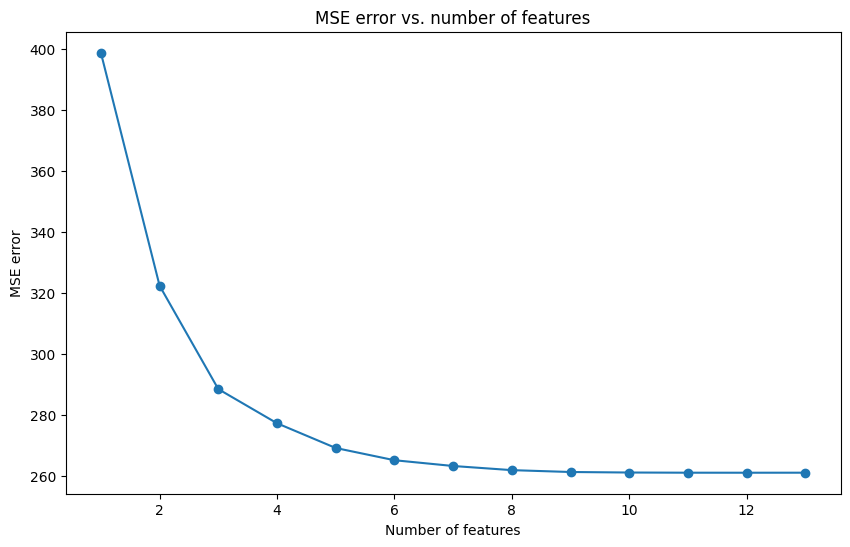

In [40]:
best_features_ext = best_features(X_train, y_train, features_extended)

* The model stabilizes around 8 features, suggesting that adding more features does not provide significant gains.

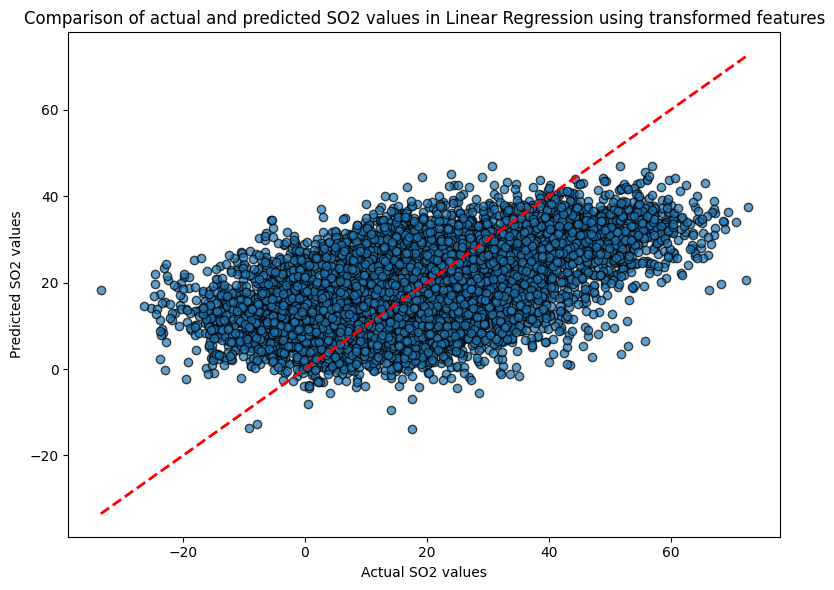

In [41]:
plot_comparison(y_test_pred, y_pred, "Comparison of actual and predicted SO2 values in Linear Regression using transformed features")

* The scatter plot shows that the model with transformed features has a better predictive ability for SO₂ than previous models.

Let's compare all the models so far and draw conclusions about the performed linear regression.

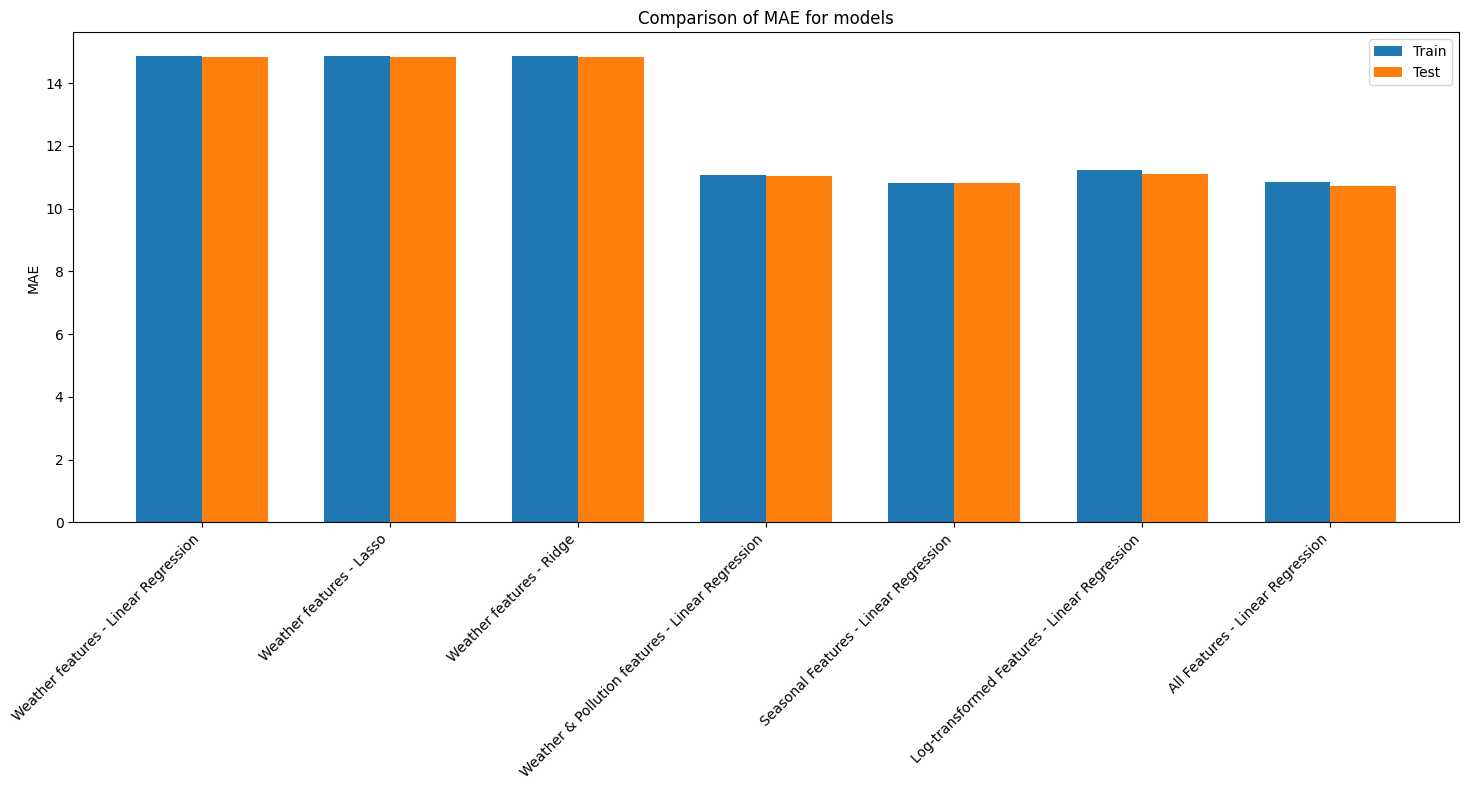

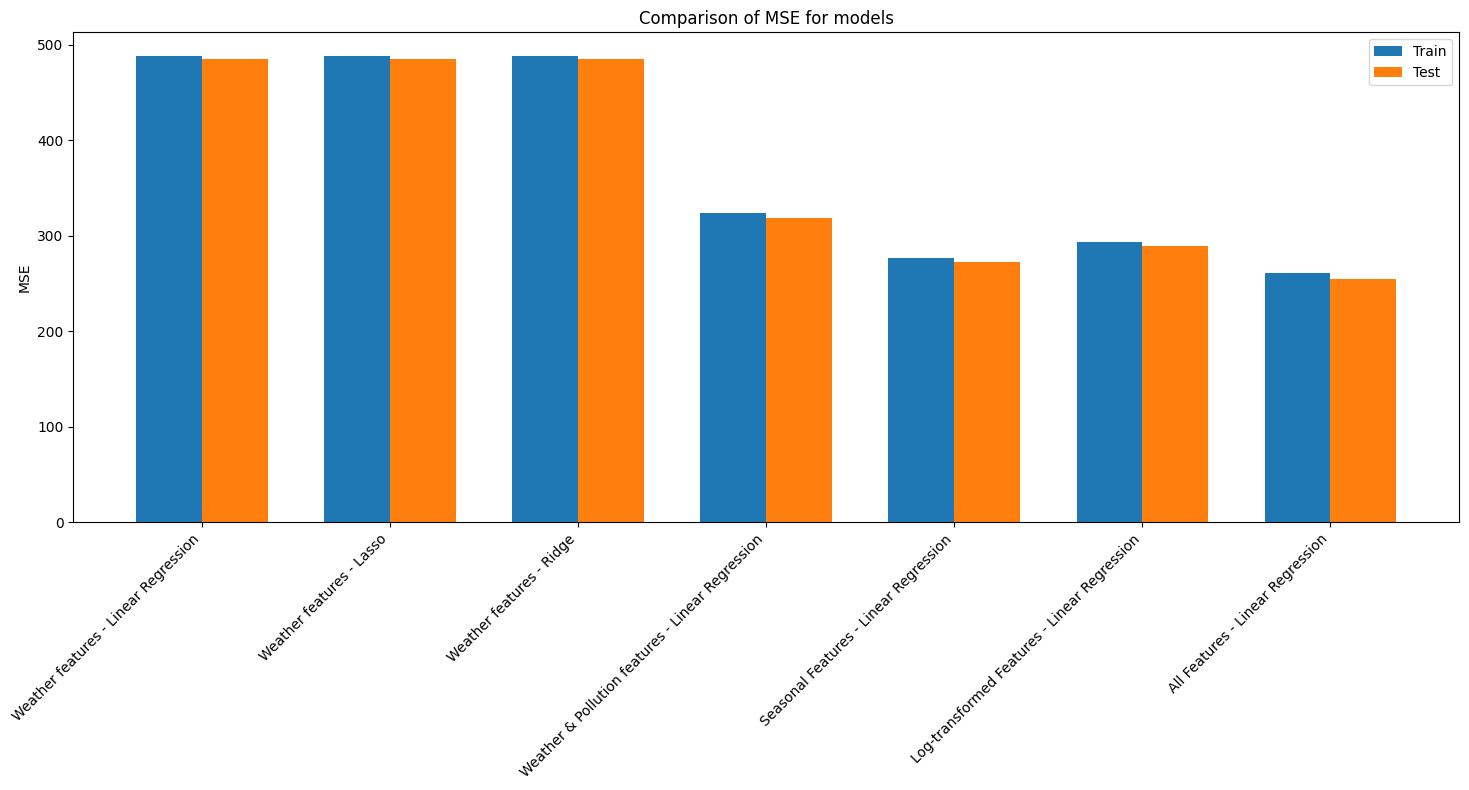

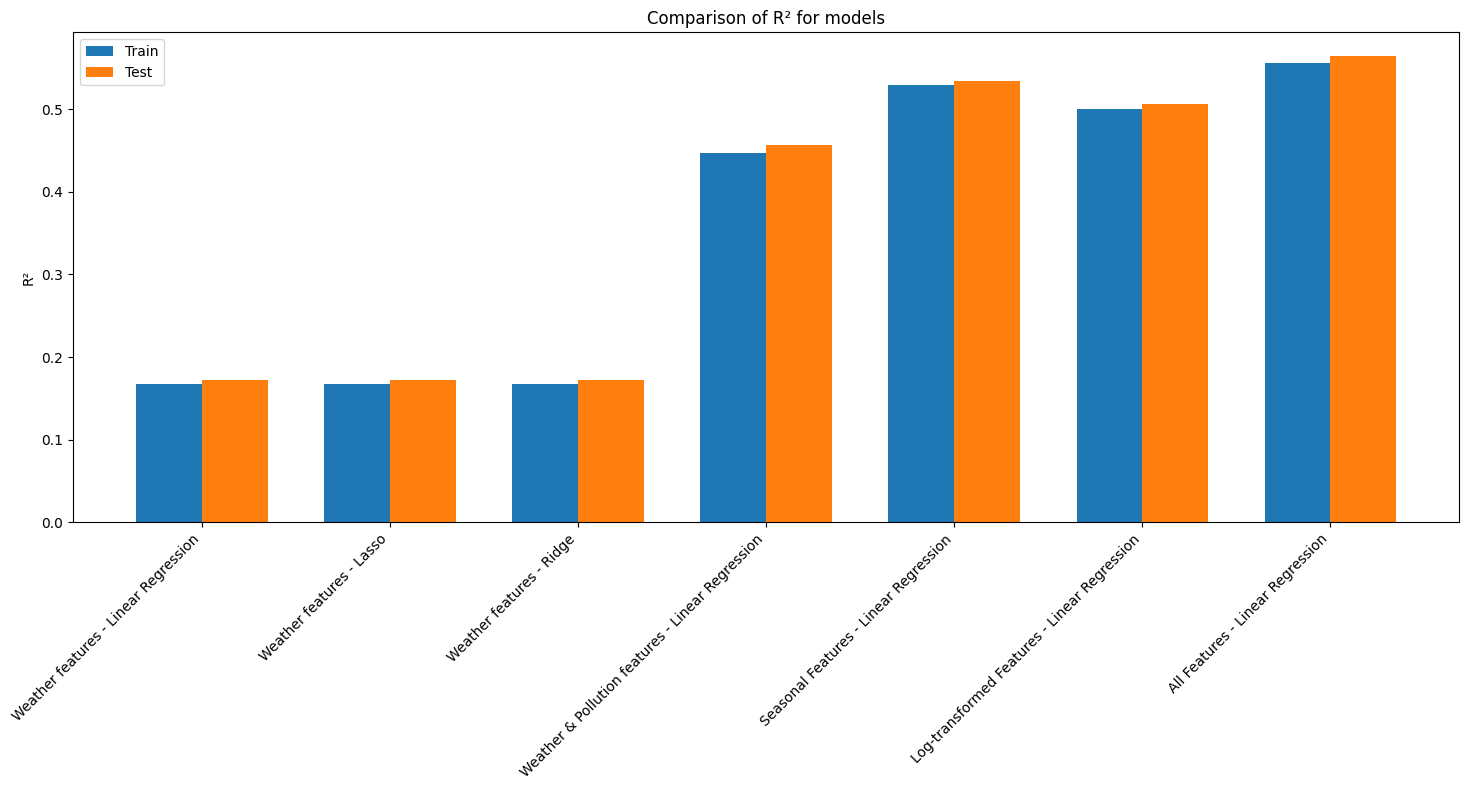

In [42]:
models = {
    "Weather features - Linear Regression": errors_linear_weather,
    "Weather features - Lasso": errors_weather_lasso,
    "Weather features - Ridge": errors_weather_ridge,
    "Weather & Pollution features - Linear Regression": errors_all,
    "Seasonal Features - Linear Regression": errors_all_ext_time,
    "Log-transformed Features - Linear Regression": errors_all_ext_log,
    "All Features - Linear Regression": errors_all_ext_all,
}
plot_model_metrics(models)

### Conclusions on Linear Regression
* Limited importance of meteorological features: The $R^2$ values for models based solely on meteorological features are very low, and the error metrics are high. Lasso and Ridge do not improve the results—indicating that the issue is not overfitting but rather a lack of complete information about SO2. **This suggests that weather conditions alone are insufficient for linearly predicting SO2 concentrations.**
* Adding pollution data significantly improves model performance: This is likely due to strong correlations between different air pollutants, which often share common emission sources.
* **Data transformations enhance predictive performance**:
    * Log-transforming variables like PM2.5, PM10, CO, and O3 reduced the impact of skewed distributions, improving the model’s ability to differentiate high SO2 concentrations.
    * Time-related features captured seasonality and long-term downward trends in SO2 levels, further improving results.
* Meteorological features have less impact when pollution data is included: In models incorporating pollution data, features like TEMP, RAIN, and wd_num were marginal. This is indicated by their low regression coefficients and the fact that Lasso regularization with higher alpha values eliminated these features without degrading model performance.
* Regularization is unnecessary: The models do not exhibit overfitting, and $R^2$ values and errors remain stable even without Ridge or Lasso. However, regularization can help stabilize coefficients, particularly in cases of multicollinearity.
* Feature selection methods (e.g., greedy selection) and regularization analysis highlight the importance of: log_CO, log_PM2.5, DEWP, log_O3, time-related features.
These variables contribute the most to explaining SO2 variability, while features like RAIN and wd_num have minimal impact.

## 2. Polynomial regression

#### 2.1.1 Polynomial regression based on meteorological data

Let's test polynomial regression models using cross-validation to evaluate the mean squared error (MSE).

In [43]:
weather_features = ['TEMP', 'PRES', 'DEWP', 'RAIN', 'WSPM', 'wd_num'] 
target = 'SO2'

X = data[weather_features]
y = data[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

degree_range = [1, 2, 3, 4, 5]
cv_results = []

for degree in degree_range:
    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('poly', PolynomialFeatures(degree=degree, include_bias=False)),
        ('linear', LinearRegression())
    ])

    scores = cross_val_score(pipeline, X_train, y_train, scoring='neg_mean_squared_error', cv=5, n_jobs=-1)

    mean_mse = -np.mean(scores)
    cv_results.append({
        'Degree': degree,
        'Mean MSE': mean_mse
    })

cv_results_df = pd.DataFrame(cv_results)
best_degree = cv_results_df.loc[cv_results_df['Mean MSE'].idxmin(), 'Degree']
display(cv_results_df)
print(f"Best polynomial degree: {best_degree}")  

,Degree,Mean MSE
0,1,488.783273
1,2,416.834212
2,3,400.917790
3,4,401.611752
4,5,18718.595381


Best polynomial degree: 3


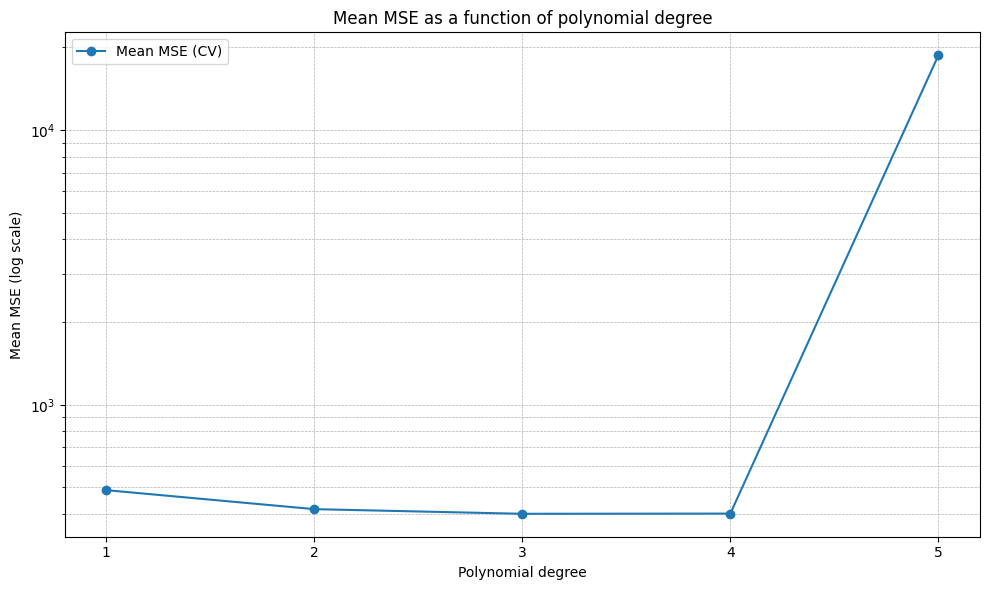

In [44]:
plt.figure(figsize=(10, 6))  
plt.plot(cv_results_df['Degree'], cv_results_df['Mean MSE'], marker='o', linestyle='-', label='Mean MSE (CV)')  
plt.xlabel('Polynomial degree')  
plt.ylabel('Mean MSE (log scale)')  
plt.title('Mean MSE as a function of polynomial degree')  
plt.xticks(degree_range)  
plt.yscale('log')  
plt.grid(True, which="both", linestyle="--", linewidth=0.5)  
plt.legend()  
plt.tight_layout()  
plt.show()  

* For lower degrees (1 and 2), the model was underfitting, leading to higher error values since it did not capture sufficiently complex relationships in the data. Degree 3 provided the lowest MSE, indicating the best fit. For degree 5, overfitting occurred, as shown by the sharp increase in MSE.

Now, let's evaluate the selected degree 3 model using validation metrics.

In [45]:
final_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('poly', PolynomialFeatures(degree=best_degree, include_bias=False)),
    ('linear', LinearRegression())
])

final_pipeline.fit(X_train, y_train)

y_test_pred = final_pipeline.predict(X_test)
y_train_pred = final_pipeline.predict(X_train)

final_metrics_weather = calculate_metrics(X_train, y_train, X_test, y_test, y_train_pred, y_test_pred)


Model metrics:


,Metric,Train,Test
0,MSE,396.93,393.94
1,RMSE,19.92,19.85
2,MAE,12.87,12.85
3,MAPE (%),164.81,166.82
4,R²,0.32,0.33
5,R² Adjusted,0.32,0.33


The polynomial regression model of degree 3 gives the best results with the lowest MSE (400.92), indicating good model fit compared to other degrees. The training and test errors are close, suggesting no excessive overfitting. However, the R² value (0.32) is relatively low.

In [46]:
def plot_top_features(pipeline, features):  
    poly_features = pipeline.named_steps['poly'].get_feature_names_out(features)  
    coefficients = pipeline.named_steps['linear'].coef_  

    importance_df = pd.DataFrame({'Feature': poly_features, 'Coefficient': coefficients}).sort_values(by='Coefficient', key=abs, ascending=False)  
    top_features = importance_df.head(5)  

    plt.figure(figsize=(10, 6))  
    plt.barh(top_features['Feature'], top_features['Coefficient'])  
    plt.xlabel('Coefficient')  
    plt.ylabel('Feature')  
    plt.title('Top features in the model')  
    plt.gca().invert_yaxis()  
    plt.tight_layout()  
    plt.show()  

    return top_features

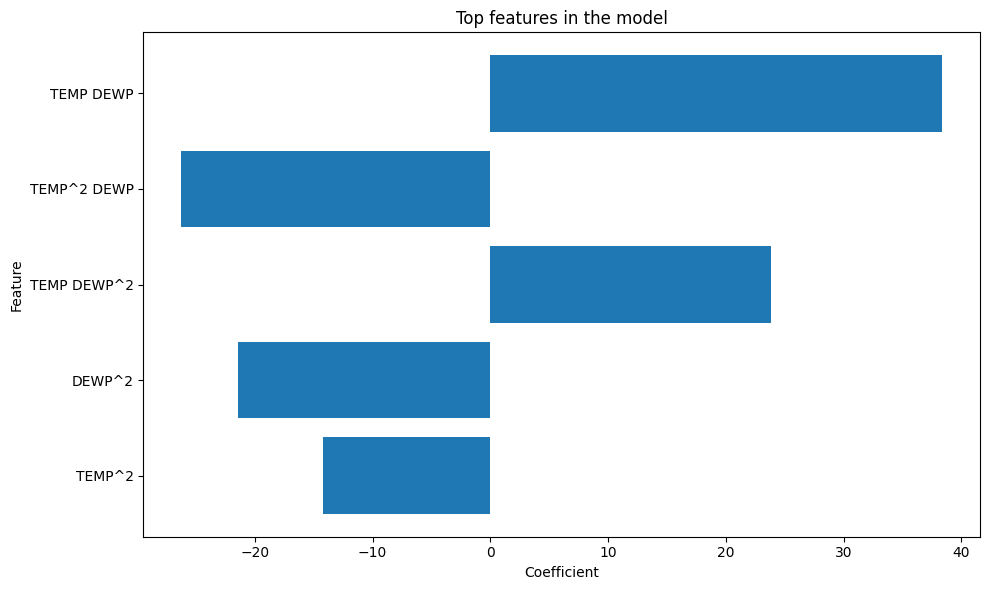

In [47]:
top_features = plot_top_features(final_pipeline, weather_features)

The most influential features in the model are interactions between temperature and dew point temperature.

#### 2.1.2 Polynomial regression based on meteorological data with Ridge Regularization

In [48]:
degree = 3
pipeline = Pipeline([
    ('scaler', StandardScaler()), 
    ('poly', PolynomialFeatures(degree=degree, include_bias=False)), 
    ('ridge', Ridge())
])

param_grid = {'ridge__alpha': [0.001, 0.1, 1, 2, 4, 10, 50, 100, 200, 400, 1000]}

grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
grid_search.fit(X_train, y_train)

print("Best alpha:", grid_search.best_params_['ridge__alpha'])  

Best alpha: 2


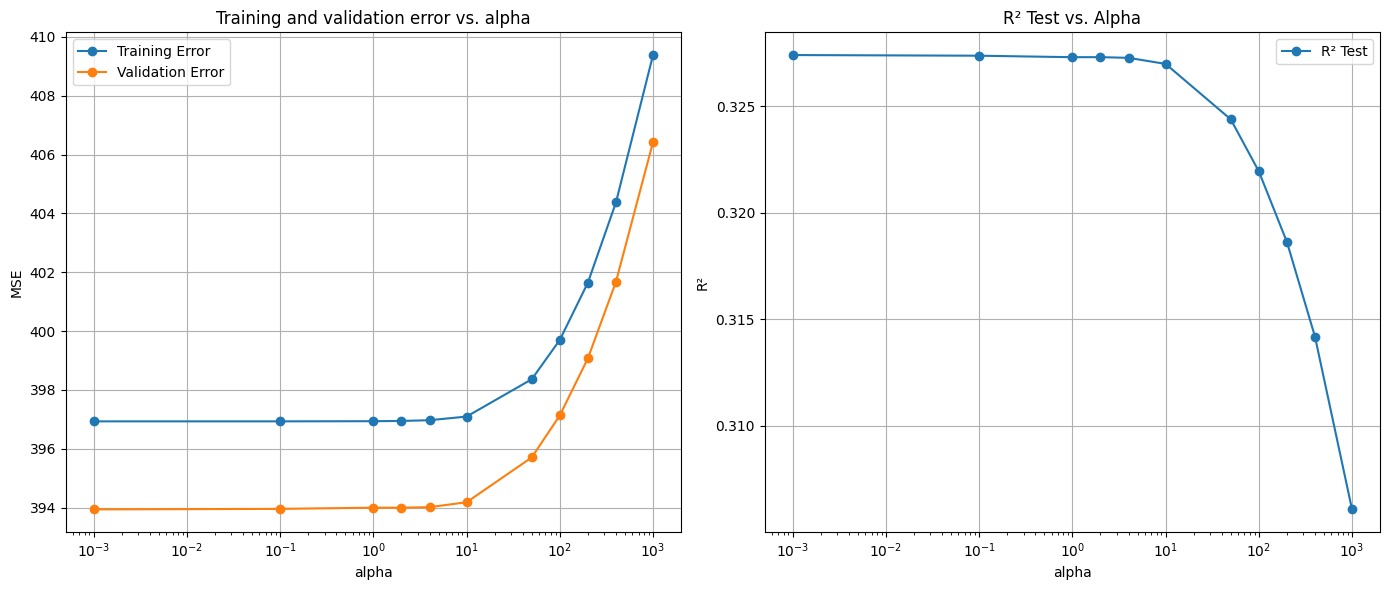

In [49]:
best_model = grid_search.best_estimator_
y_test_pred = best_model.predict(X_test)
y_train_pred = best_model.predict(X_train)
metrics_per_alpha_ridge = []

for alpha in param_grid['ridge__alpha']:
    pipeline.set_params(ridge__alpha=alpha)
    pipeline.fit(X_train, y_train)
    y_test_pred = pipeline.predict(X_test)
    y_train_pred = pipeline.predict(X_train)

    mse_train = mean_squared_error(y_train, y_train_pred)
    mse_test = mean_squared_error(y_test, y_test_pred)
    r2_test = r2_score(y_test, y_test_pred)
    
    metrics_per_alpha_ridge.append({
        "Alpha": alpha,
        "MSE Train": mse_train,
        "MSE Test": mse_test,
        "R² Test": r2_test
    })

df_metrics_ridge = pd.DataFrame(metrics_per_alpha_ridge)


plot_metrics(df_metrics_ridge)

For increasing alpha values, both test and training MSE values start rising, and the model's $R^2$ score decreases. Alpha = 2 provides the best balance, ensuring moderate regularization.

In [50]:
final_metrics_weather_ridge = calculate_metrics(X_train, y_train, X_test, y_test, y_train_pred, y_test_pred)


Model metrics:


,Metric,Train,Test
0,MSE,409.38,406.43
1,RMSE,20.23,20.16
2,MAE,13.00,12.98
3,MAPE (%),168.89,169.94
4,R²,0.30,0.31
5,R² Adjusted,0.30,0.31


Ridge regularization with alpha = 2 maintains similar, but slightly lower test and train metrics.

#### 2.1.3 Polynomial regression based on meteorological data with Lasso Regularization

In [51]:
degree = 3

pipeline = Pipeline([
    ('scaler', StandardScaler()), 
    ('poly', PolynomialFeatures(degree=degree, include_bias=False)), 
    ('lasso', Lasso(max_iter=10000, random_state=42))
])

param_grid = {'lasso__alpha': [0.01, 0.1, 1, 10, 100, 1000]}

grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
grid_search.fit(X_train, y_train)

print("Best alpha:", grid_search.best_params_['lasso__alpha'])

Best alpha: 0.01


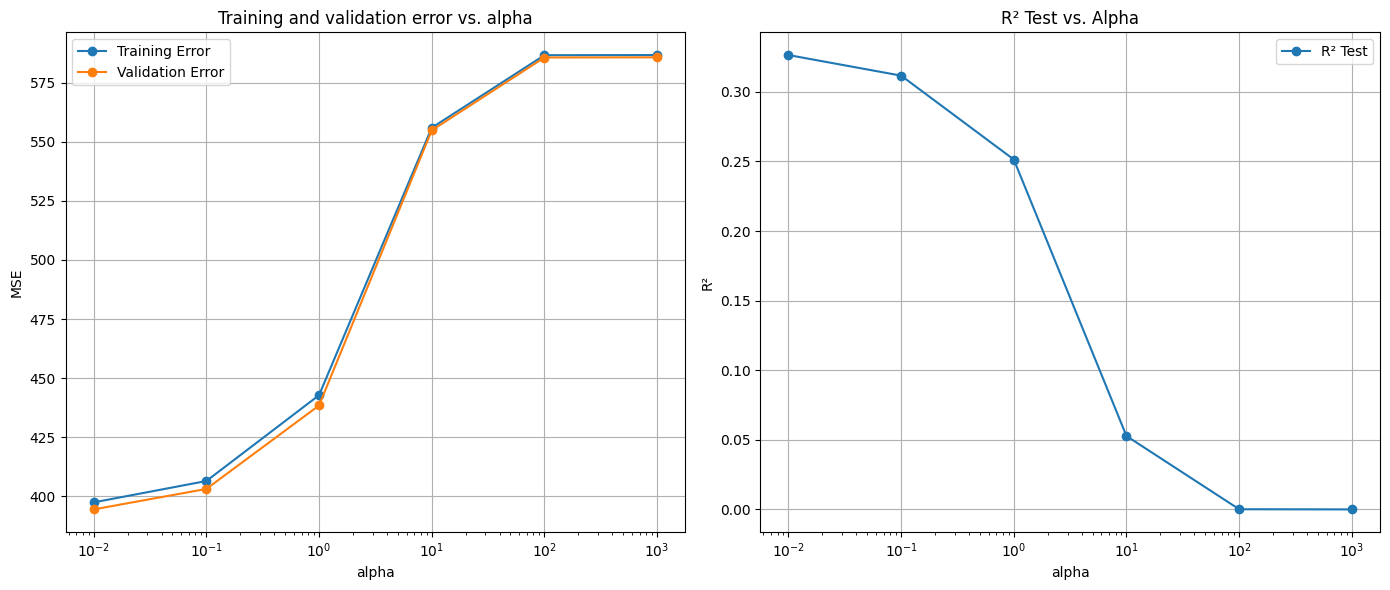

In [52]:
metrics_per_alpha_lasso = []

for alpha in param_grid['lasso__alpha']:
    pipeline.set_params(lasso__alpha=alpha)
    pipeline.fit(X_train, y_train)
    y_test_pred = pipeline.predict(X_test)
    y_train_pred = pipeline.predict(X_train)

    mse_train = mean_squared_error(y_train, y_train_pred)
    mse_test = mean_squared_error(y_test, y_test_pred)
    r2_test = r2_score(y_test, y_test_pred)
    
    metrics_per_alpha_lasso.append({
        "Alpha": alpha,
        "MSE Train": mse_train,
        "MSE Test": mse_test,
        "R² Test": r2_test
    })

df_metrics_lasso = pd.DataFrame(metrics_per_alpha_lasso)
plot_metrics(df_metrics_lasso)

In [53]:
best_pipeline = grid_search.best_estimator_
best_pipeline.fit(X_train, y_train)
y_test_pred = best_pipeline.predict(X_test)
y_train_pred = best_pipeline.predict(X_train)

poly_features = best_pipeline.named_steps['poly'].get_feature_names_out(X_train.columns)
lasso_coefficients = best_pipeline.named_steps['lasso'].coef_

coefficients_df = pd.DataFrame({
    'Feature': poly_features,
    'Coefficient': lasso_coefficients
}).sort_values(by='Coefficient', ascending=False)

zeroed_features = coefficients_df[coefficients_df['Coefficient'] == 0.0]
print("\nZeroed features:")
print(zeroed_features)

final_metrics_weather_lasso = calculate_metrics(X_train, y_train, X_test, y_test, y_train_pred, y_test_pred)


Zeroed features:
             Feature  Coefficient
43    TEMP RAIN WSPM         -0.0
48            PRES^3          0.0
54    PRES DEWP RAIN         -0.0
59  PRES RAIN wd_num         -0.0
69  DEWP RAIN wd_num         -0.0
14         PRES RAIN          0.0
4               WSPM         -0.0
64       DEWP^2 RAIN          0.0
35    TEMP PRES RAIN          0.0
18         DEWP RAIN          0.0
19         DEWP WSPM          0.0
33       TEMP PRES^2          0.0
31       TEMP^2 WSPM         -0.0
39    TEMP DEWP RAIN         -0.0

Model metrics:


,Metric,Train,Test
0,MSE,397.47,394.49
1,RMSE,19.94,19.86
2,MAE,12.85,12.82
3,MAPE (%),164.39,166.02
4,R²,0.32,0.33
5,R² Adjusted,0.32,0.33


* Lasso eliminates redundant features, making the model more interpretable and robust to noise.

Let's compare the polynomial regression metrics and see if polynomial regression is better than linear in this case.

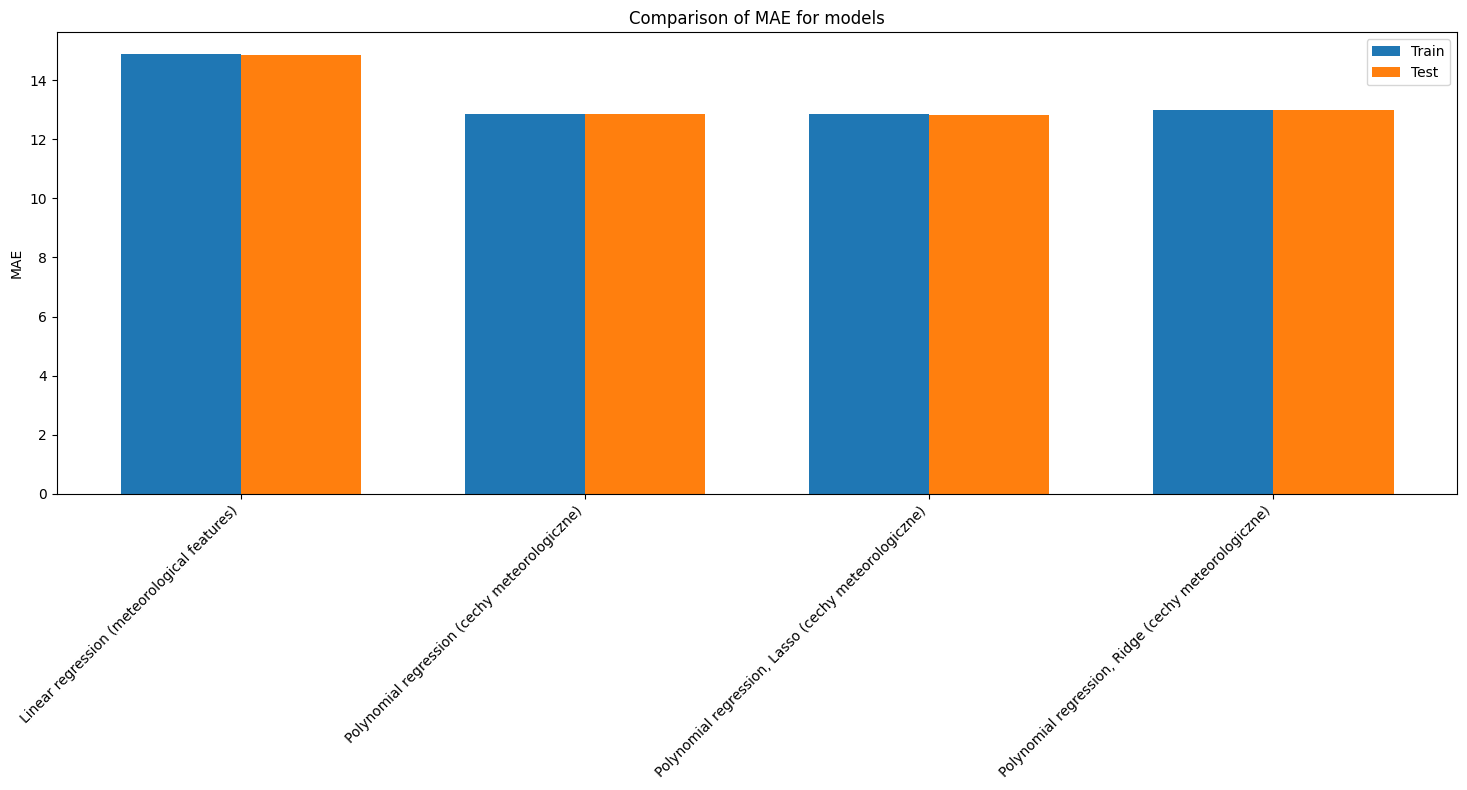

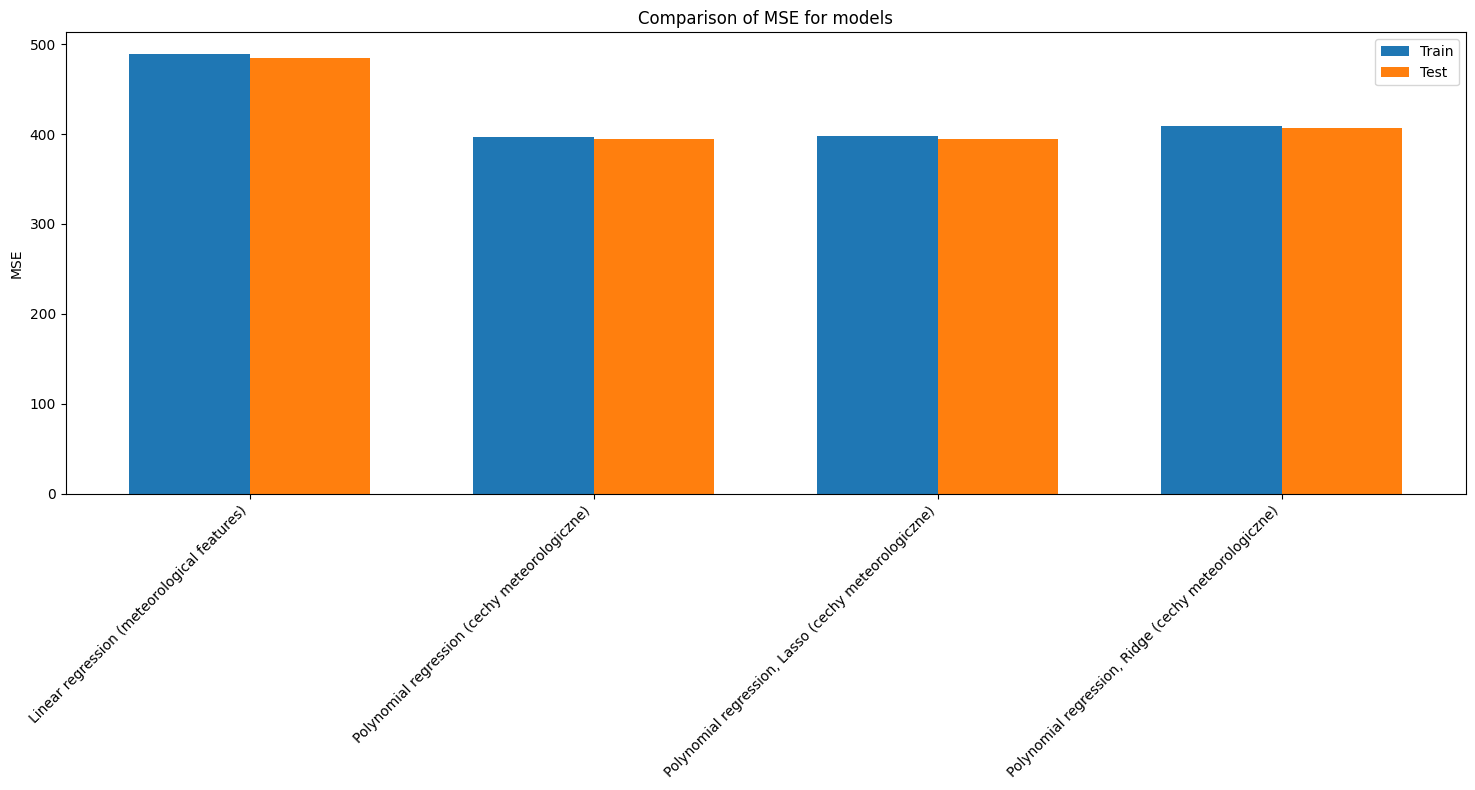

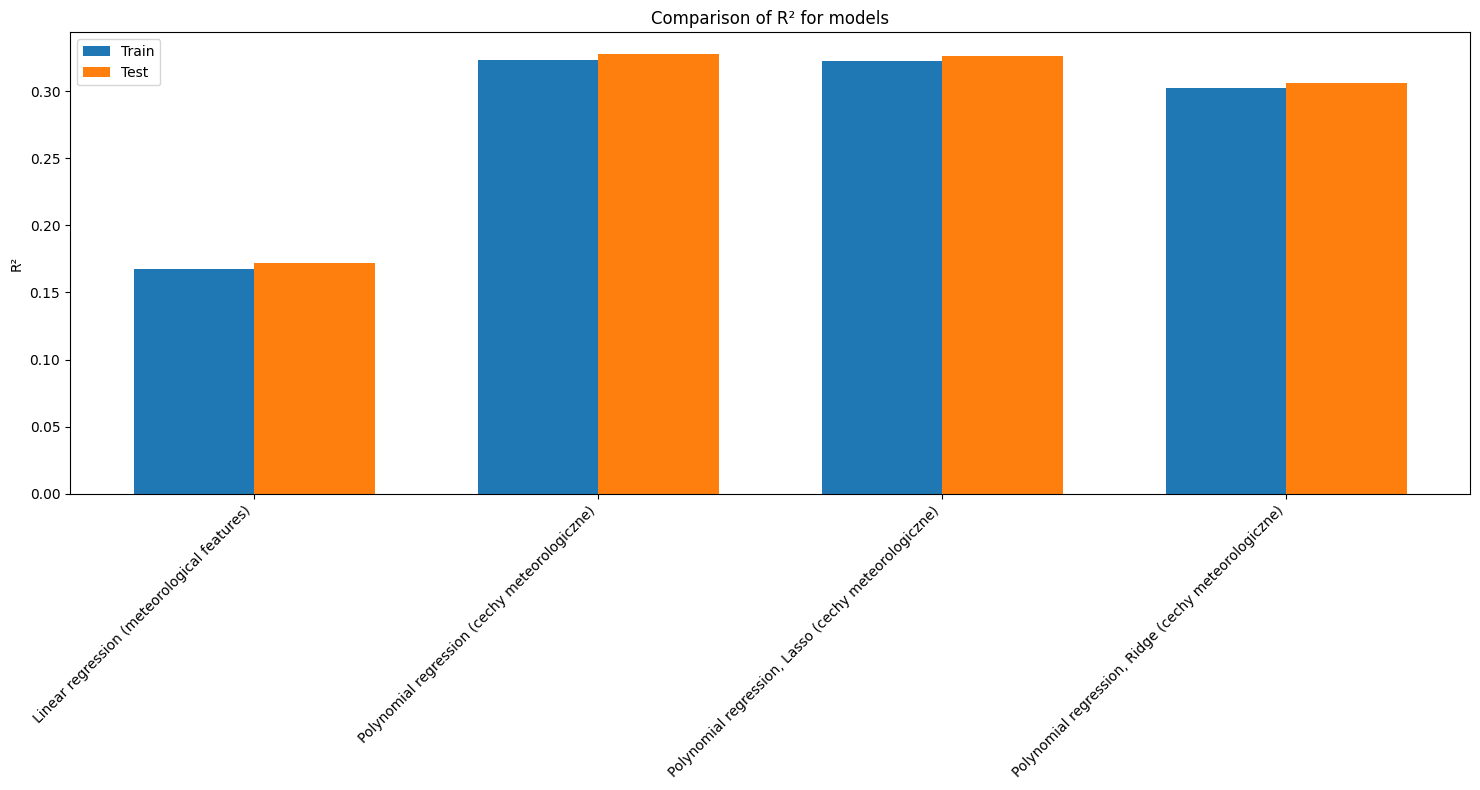

In [54]:
models = {
    "Linear regression (meteorological features)": errors_linear_weather,
    "Polynomial regression (cechy meteorologiczne)": final_metrics_weather,
    "Polynomial regression, Lasso (cechy meteorologiczne)": final_metrics_weather_lasso,
    "Polynomial regression, Ridge (cechy meteorologiczne)": final_metrics_weather_ridge,
}
plot_model_metrics(models)

Polynomial regression achieved the lowest error values. However, $R^2$ remains low (0.34), indicating that meteorological data alone does not explain a high percentage of SO2 variability.

#### 2.2.1 Polynomial regression based on meteorological and pollutant features

In [55]:
features = ['PM2.5', 'PM10', 'NO2', 'CO', 'O3', 'TEMP', 'PRES', 'DEWP', 'RAIN', 'WSPM', 'wd_num'] 
target = 'SO2'

X = data[features]
y = data[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

degree_range = [1, 2, 3, 4]
cv_results = []

for degree in degree_range:
    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('poly', PolynomialFeatures(degree=degree, include_bias=False)),
        ('linear', LinearRegression())
    ])

    scores = cross_val_score(pipeline, X_train, y_train, scoring='neg_mean_squared_error', cv=5, n_jobs=-1)

    mean_mse = -np.mean(scores)
    cv_results.append({
        'Degree': degree,
        'Mean MSE': mean_mse
    })

cv_results_df = pd.DataFrame(cv_results)
best_degree = cv_results_df.loc[cv_results_df['Mean MSE'].idxmin(), 'Degree']
display(cv_results_df)
print(f"Best polynomial degree: {best_degree}")

,Degree,Mean MSE
0,1,324.969676
1,2,192.809943
2,3,207.548889
3,4,166825.864767


Best polynomial degree: 2


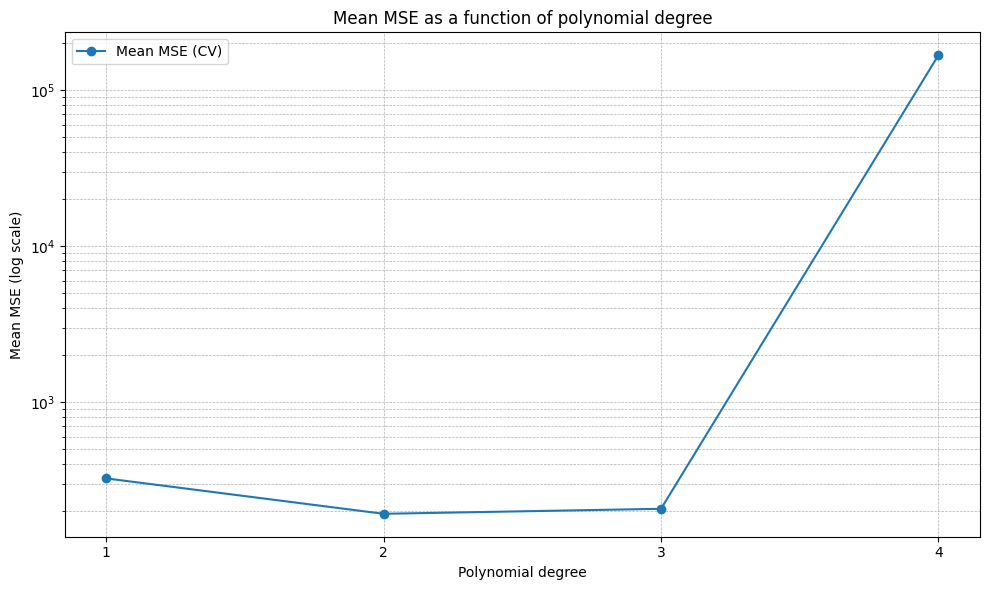

In [56]:
plt.figure(figsize=(10, 6))  
plt.plot(cv_results_df['Degree'], cv_results_df['Mean MSE'], marker='o', linestyle='-', label='Mean MSE (CV)')  
plt.xlabel('Polynomial degree')  
plt.ylabel('Mean MSE (log scale)')  
plt.title('Mean MSE as a function of polynomial degree')  
plt.xticks(degree_range)  
plt.yscale('log')  
plt.grid(True, which="both", linestyle="--", linewidth=0.5)  
plt.legend()  
plt.tight_layout()  
plt.show()  

* Using cross-validation, we observe that a polynomial of degree 2 achieves the lowest mean squared error (MSE).
* Higher degrees lead to increasing error – for instance, degree 4 results in extremely high MSE due to overfitting caused by a large number of features.

In [57]:
final_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('poly', PolynomialFeatures(degree=best_degree, include_bias=False)),
    ('linear', LinearRegression())
])

final_pipeline.fit(X_train, y_train)

y_test_pred = final_pipeline.predict(X_test)
y_train_pred = final_pipeline.predict(X_train)

final_metrics_all = calculate_metrics(X_train, y_train, X_test, y_test, y_train_pred, y_test_pred)


Model metrics:


,Metric,Train,Test
0,MSE,190.55,194.41
1,RMSE,13.80,13.94
2,MAE,8.19,8.34
3,MAPE (%),83.04,83.65
4,R²,0.68,0.67
5,R² Adjusted,0.68,0.67


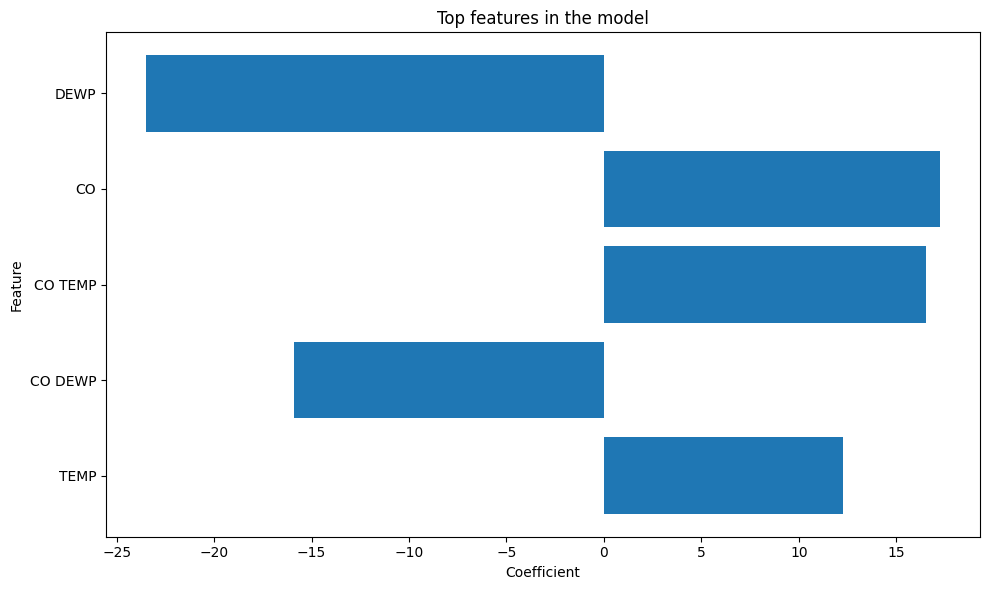

In [58]:
top_features = plot_top_features(final_pipeline, features)

* The inclusion of additional features (other pollutants) significantly improves model performance. The MSE for the best model (degree 2) with all features is over 50% lower than for the best model (degree 3) with only meteorological features.
* Interestingly, the most important features are dew point temperature, carbon monoxide, temperature, and their interactions.
* An $R^2$ of 0.67 on the test set suggests that the model generalizes well to new data without overfitting. The difference between training and test set performance is minimal, indicating model stability.

#### 2.2.2 Polynomial regression based on meteorological and pollutant features with Ridge Regularization

In [59]:
degree = 2
pipeline = Pipeline([
    ('scaler', StandardScaler()), 
    ('poly', PolynomialFeatures(degree=degree, include_bias=False)), 
    ('ridge', Ridge())
])

param_grid = {'ridge__alpha': [0.1, 1, 2, 6, 8, 10, 20, 40, 60, 80, 100, 400, 600, 1000, 2000]}

grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
grid_search.fit(X_train, y_train)

print("Best alpha:", grid_search.best_params_['ridge__alpha'])

Best alpha: 10


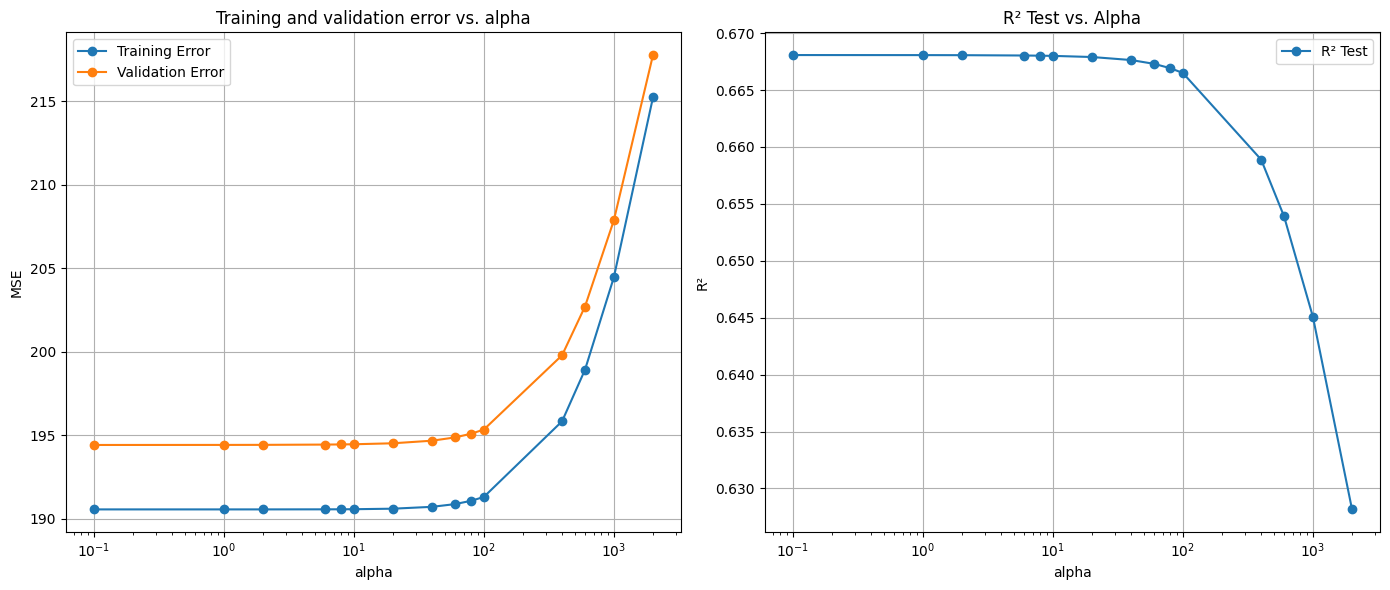

In [60]:
best_model = grid_search.best_estimator_
y_test_pred = best_model.predict(X_test)
y_train_pred = best_model.predict(X_train)
metrics_per_alpha_ridge = []

for alpha in param_grid['ridge__alpha']:
    pipeline.set_params(ridge__alpha=alpha)
    pipeline.fit(X_train, y_train)
    y_test_pred = pipeline.predict(X_test)
    y_train_pred = pipeline.predict(X_train)
    
    mse_train = mean_squared_error(y_train, y_train_pred)
    mse_test = mean_squared_error(y_test, y_test_pred)
    r2_test = r2_score(y_test, y_test_pred)
    
    metrics_per_alpha_ridge.append({
        "Alpha": alpha,
        "MSE Train": mse_train,
        "MSE Test": mse_test,
        "R² Test": r2_test
    })

df_metrics_ridge = pd.DataFrame(metrics_per_alpha_ridge)
plot_metrics(df_metrics_ridge)

In [61]:
final_metrics_ridge = calculate_metrics(X_train, y_train, X_test, y_test, y_train_pred, y_test_pred)


Model metrics:


,Metric,Train,Test
0,MSE,215.24,217.78
1,RMSE,14.67,14.76
2,MAE,8.86,8.96
3,MAPE (%),97.24,98.77
4,R²,0.63,0.63
5,R² Adjusted,0.63,0.63


Ridge regularization slightly improves model stability by reducing multicollinearity among features. However, the performance metrics are very similar to the results without regularization.

#### 2.2.3 Polynomial regression based on meteorological and pollutant features with Lasso Regularization

In [62]:
degree = 2

pipeline = Pipeline([
    ('scaler', StandardScaler()), 
    ('poly', PolynomialFeatures(degree=degree, include_bias=False)), 
    ('lasso', Lasso(max_iter=10000, random_state=42))
])

param_grid = {'lasso__alpha': [0.001, 0.01, 0.1, 1, 10, 100, 1000]}

grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
grid_search.fit(X_train, y_train)

print("Best alpha:", grid_search.best_params_['lasso__alpha'])

Best alpha: 0.01


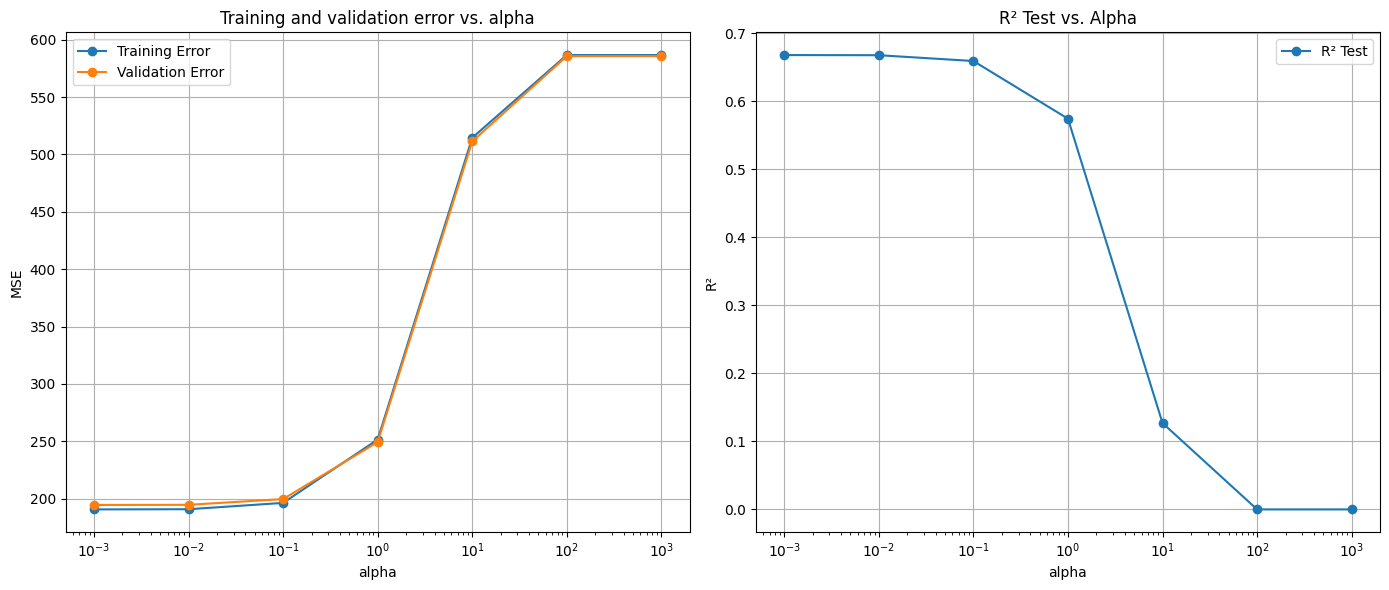

In [63]:
metrics_per_alpha_lasso = []

for alpha in param_grid['lasso__alpha']:
    pipeline.set_params(lasso__alpha=alpha)
    pipeline.fit(X_train, y_train)
    y_test_pred = pipeline.predict(X_test)
    y_train_pred = pipeline.predict(X_train)

    mse_train = mean_squared_error(y_train, y_train_pred)
    mse_test = mean_squared_error(y_test, y_test_pred)
    r2_test = r2_score(y_test, y_test_pred)
    
    metrics_per_alpha_lasso.append({
        "Alpha": alpha,
        "MSE Train": mse_train,
        "MSE Test": mse_test,
        "R² Test": r2_test
    })

df_metrics_lasso = pd.DataFrame(metrics_per_alpha_lasso)
plot_metrics(df_metrics_lasso)

In [64]:
best_pipeline = grid_search.best_estimator_
best_pipeline.fit(X_train, y_train)
y_test_pred = best_pipeline.predict(X_test)
y_train_pred = best_pipeline.predict(X_train)

poly_features = best_pipeline.named_steps['poly'].get_feature_names_out(X_train.columns)
lasso_coefficients = best_pipeline.named_steps['lasso'].coef_

coefficients_df = pd.DataFrame({
    'Feature': poly_features,
    'Coefficient': lasso_coefficients
}).sort_values(by='Coefficient', ascending=False)

zeroed_features = coefficients_df[coefficients_df['Coefficient'] == 0.0]
print("\nZeroed coefficients:")
print(zeroed_features)

final_metrics_lasso = calculate_metrics(X_train, y_train, X_test, y_test, y_train_pred, y_test_pred)


Zeroed coefficients:
         Feature  Coefficient
66   PRES wd_num         -0.0
51       O3 PRES         -0.0
38      NO2 RAIN          0.0
21  PM2.5 wd_num         -0.0
36      NO2 PRES          0.0
8           RAIN         -0.0
17    PM2.5 PRES         -0.0

Model metrics:


,Metric,Train,Test
0,MSE,190.71,194.56
1,RMSE,13.81,13.95
2,MAE,8.17,8.32
3,MAPE (%),82.20,82.93
4,R²,0.67,0.67
5,R² Adjusted,0.67,0.67


* The best alpha parameter value is 0.01, which indicates a low level of regularization. Higher parameter values resulted in excessive model simplification and deterioration of results.
* Lasso removes insignificant features, and the model results are very similar to those without regularization.

#### 2.3.1 Polynomial regression based on transformed and seasonal features

Since the linear model with transformed and seasonal features proved to be the best one, let's check how well these features work with polynomial regression.

In [65]:
data['log_PM2.5'] = np.log1p(data['PM2.5'])
data['log_PM10'] = np.log1p(data['PM10'])
data['log_CO'] = np.log1p(data['CO'])
data['log_O3'] = np.log1p(data['O3'])
data['month_sin'] = np.sin(2 * np.pi * data['month'] / 12)
data['month_cos'] = np.cos(2 * np.pi * data['month'] / 12)
data['time'] = (data['year'] - data['year'].min()) * 12 + data['month']

In [66]:
features_extended = ['TEMP', 'PRES', 'DEWP', 'RAIN', 'WSPM', 'wd_num', 'log_PM2.5', 'log_PM10', 'log_CO', 'log_O3','month_sin', 'month_cos', 'time']

X = data[features_extended]
y = data['SO2']

In [67]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

degree_range = [1, 2, 3]
cv_results = []

for degree in degree_range:
    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('poly', PolynomialFeatures(degree=degree, include_bias=False)),
        ('linear', LinearRegression())
    ])

    scores = cross_val_score(pipeline, X_train, y_train, scoring='neg_mean_squared_error', cv=5, n_jobs=-1)

    mean_mse = -np.mean(scores)
    cv_results.append({
        'Degree': degree,
        'Mean MSE': mean_mse
    })

cv_results_df = pd.DataFrame(cv_results)
best_degree = cv_results_df.loc[cv_results_df['Mean MSE'].idxmin(), 'Degree']
display(cv_results_df)
print(f"Best polynomial degree: {best_degree}")

,Degree,Mean MSE
0,1,260.976301
1,2,142.429691
2,3,117.374490


Best polynomial degree: 3


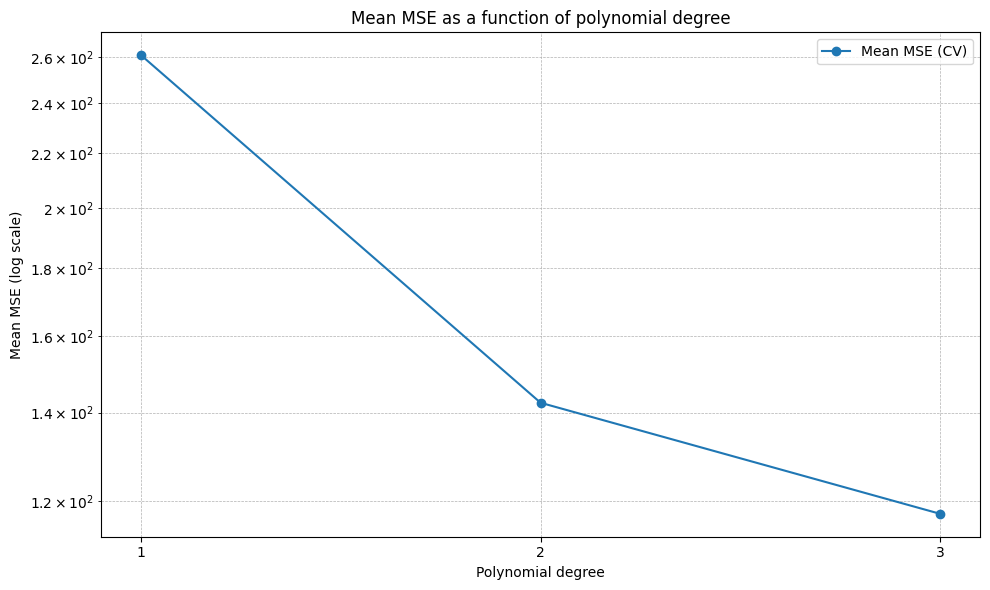

In [68]:
plt.figure(figsize=(10, 6))  
plt.plot(cv_results_df['Degree'], cv_results_df['Mean MSE'], marker='o', linestyle='-', label='Mean MSE (CV)')  
plt.xlabel('Polynomial degree')  
plt.ylabel('Mean MSE (log scale)')  
plt.title('Mean MSE as a function of polynomial degree')  
plt.xticks(degree_range)  
plt.yscale('log')  
plt.grid(True, which="both", linestyle="--", linewidth=0.5)  
plt.legend()  
plt.tight_layout()  
plt.show()  

Due to a high number of features and a relatively high polynomial degree, we are able to only check the mean squared error for degrees up to 3. Most likely, the 4th degree would cause overfitting, so let's check the metrics for best degree we got from cross validation.

In [69]:
final_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('poly', PolynomialFeatures(degree=best_degree, include_bias=False)),
    ('linear', LinearRegression())
])

final_pipeline.fit(X_train, y_train)

y_test_pred = final_pipeline.predict(X_test)
y_train_pred = final_pipeline.predict(X_train)

final_metrics_ext = calculate_metrics(X_train, y_train, X_test, y_test, y_train_pred, y_test_pred)


Model metrics:


,Metric,Train,Test
0,MSE,98.99,103.93
1,RMSE,9.95,10.19
2,MAE,6.14,6.35
3,MAPE (%),67.83,70.38
4,R²,0.83,0.82
5,R² Adjusted,0.83,0.82


We were able to achieve RMSE as low as 10 and $R^2$ coefficient as high as 0.82, without overfitting - since the $R^2$ values are very similar for both the training and test set.

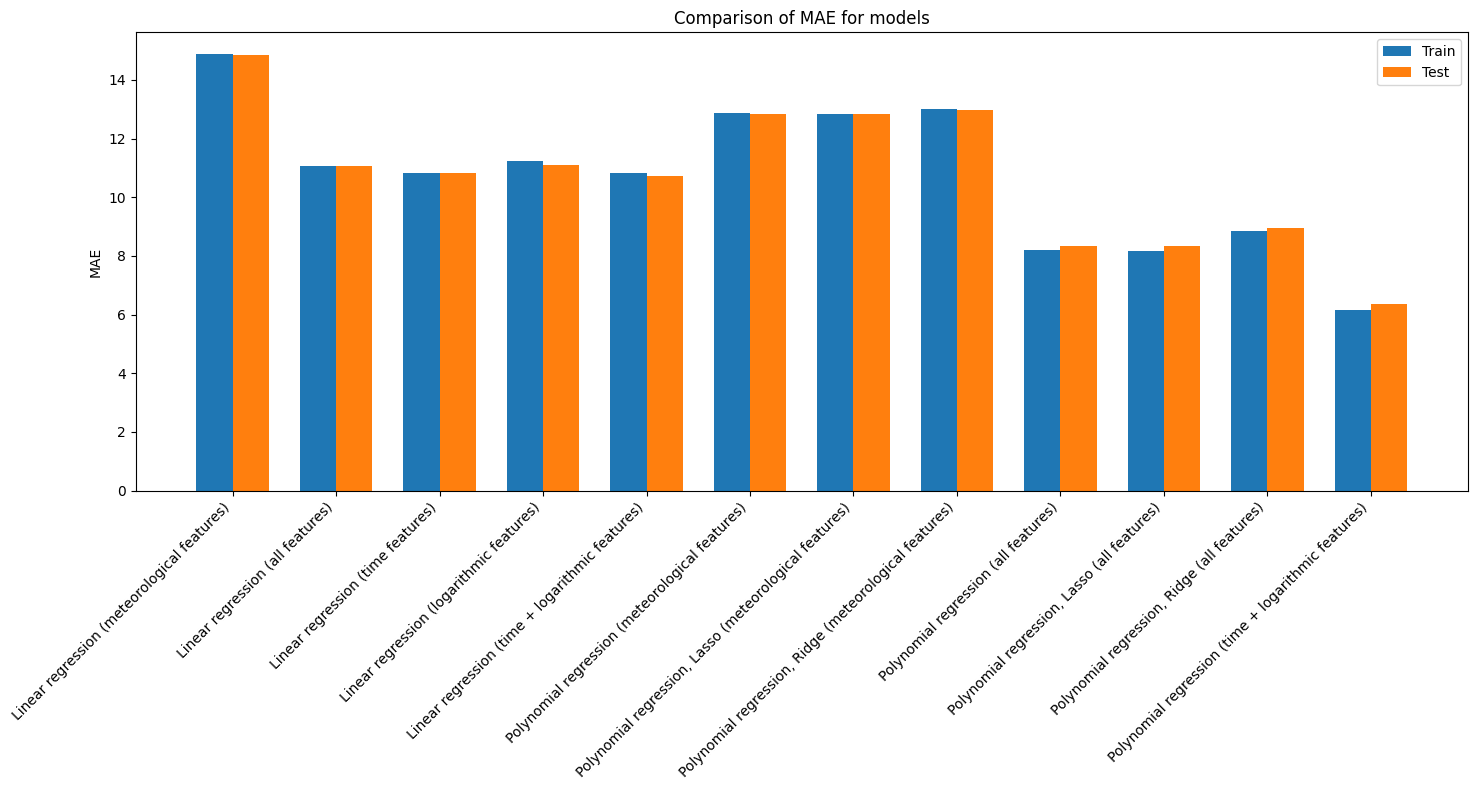

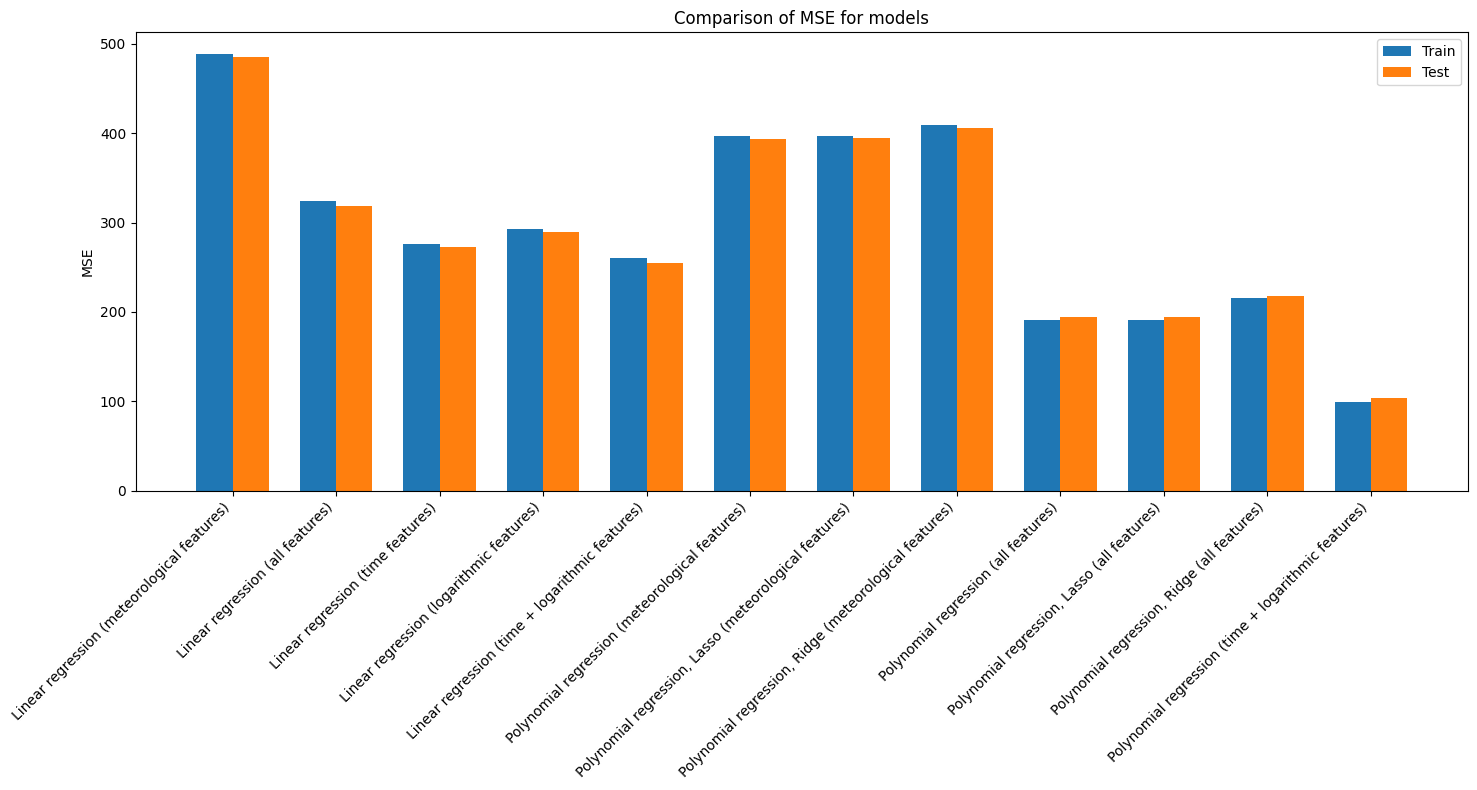

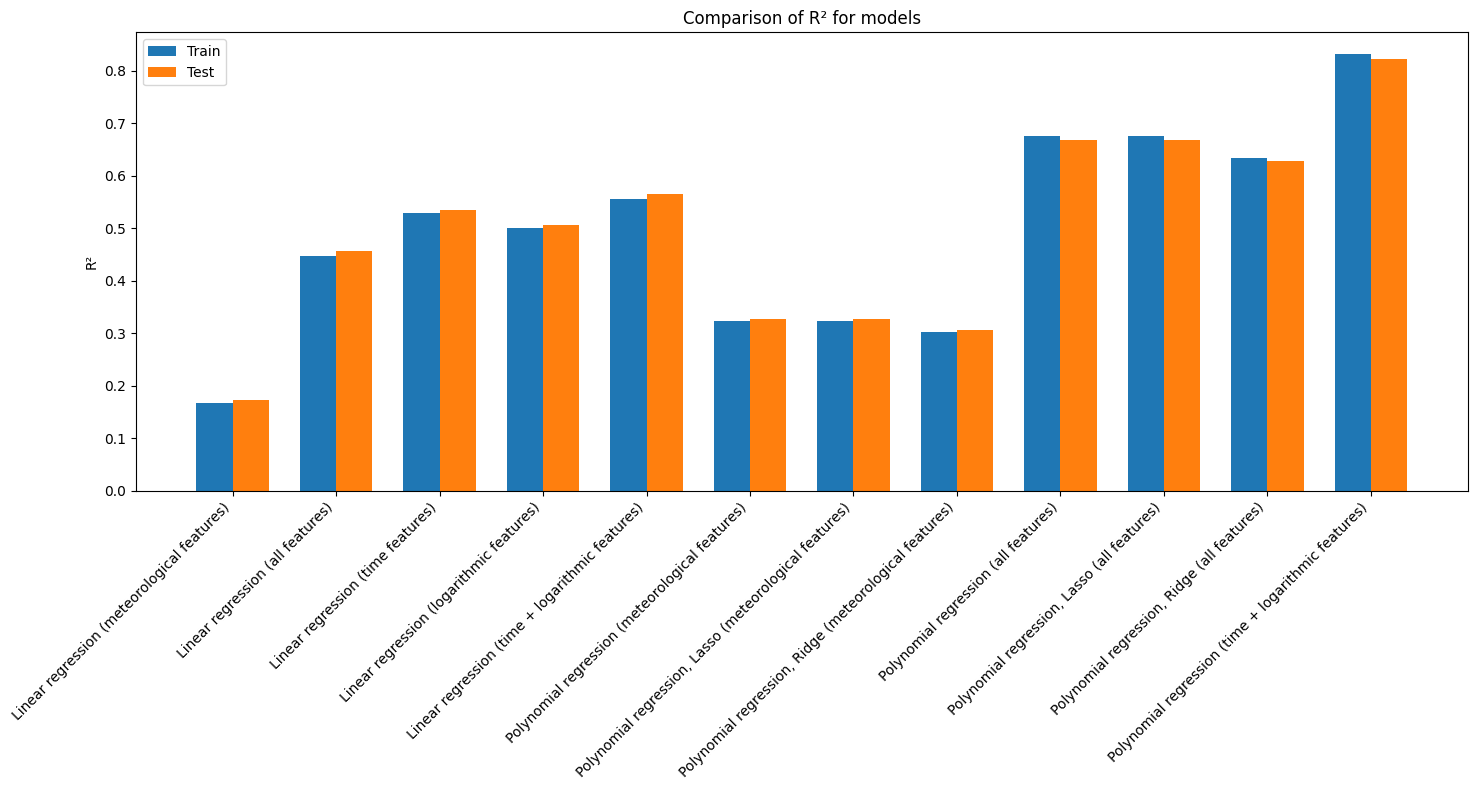

In [70]:
models = {
    "Linear regression (meteorological features)": errors_linear_weather,
    "Linear regression (all features)": errors_all,
    "Linear regression (time features)": errors_all_ext_time,
    "Linear regression (logarithmic features)": errors_all_ext_log,
    "Linear regression (time + logarithmic features)": errors_all_ext_all,
    "Polynomial regression (meteorological features)": final_metrics_weather,
    "Polynomial regression, Lasso (meteorological features)": final_metrics_weather_lasso,
    "Polynomial regression, Ridge (meteorological features)": final_metrics_weather_ridge,
    "Polynomial regression (all features)": final_metrics_all,
    "Polynomial regression, Lasso (all features)": final_metrics_lasso,
    "Polynomial regression, Ridge (all features)": final_metrics_ridge,
    "Polynomial regression (time + logarithmic features)": final_metrics_ext,
}

plot_model_metrics(models)

## Summary

* SO2 prediction based on meteorological features
     * The significance of meteorological features alone is limited. Models based solely on weather (TEMP, PRES, DEWP, RAIN, WSPM, wd_num) achieved low fitting coefficient values. Despite improvement after switching to a 3rd-degree polynomial model, this still represents a low ability to predict sulfur dioxide concentration (approx. 0.17 in linear regression, approx. 0.33 in polynomial regression).
    * Regularization (Lasso, Ridge) does not significantly improve results for weather parameters alone, as the model does not tend to overfit – the problem is rather underfitting (lack of sufficient information in the features).
* Inclusion of other pollutants
    * Adding features such as PM2.5, PM10, NO2, CO, O3 significantly reduced the error and increased R2 to ~0.45-0.46 even in linear regression. This indicates that other pollutants are strongly correlated with SO2 (they may come from similar emission sources), which greatly improves model fit.
* Feature transformations
    * Including time features captured the seasonality and downward trend of SO2 concentration in the studied period, providing additional improvement in model results.
Logarithmic transformation of features with skewed distributions improved the prediction of high values of the dependent variable, reducing errors.
* Polynomial models with all features
    * When considering all features and building a 2nd-degree model, we achieve further improvement in prediction quality.
Regularization (Ridge/Lasso) with 2nd-degree polynomials brings only minor changes – sometimes stabilizing coefficients in the face of collinearity, but not necessarily significantly reducing error.
* Role of regularization
    * Lasso doesn't zero out too many features, as each somewhat improves MSE error. At higher regularization parameters, it removes some features, but results don't improve.
Ridge regularization stabilizes coefficients and limits the collinearity problem, but also doesn't provide much better model results. However, it is useful with complex polynomials to avoid excessive weight growth.
* Best results
    * The best results - lowest RMSE error of about 10 and highest $R^2$ coefficient of 0.82 - are achieved by the polynomial model (degree 2) using meteorologic, pollutant and transformed features.